# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
# Step 0: Load The Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
os.chdir('My Drive/Colab Notebooks/traffic/CarND-Traffic-Sign-Classifier-Project')

In [0]:
!ls

 CODEOWNERS	 README.md			 visualize_cnn.png
 custom_images	 report.html			 writeup_material
 examples	 signnames.csv			'writeup_template (1).md'
 models		 Traffic_Sign_Classifier.ipynb	 writeup_template.md
 __pycache__	 utils.py


In [0]:
# Visualizations will be shown in the notebook.
%matplotlib inline
from importlib import reload
import utils; reload(utils)
from utils import *

In [0]:
# Import crucial modules
import pickle
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
import time

In [0]:
datasets_path = "../datasets/german_traffic_signs/"
models_path = "./models/"

training_file = datasets_path + 'train.p'
validation_file= datasets_path + 'valid.p'
testing_file = datasets_path + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

## Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [0]:
# Let's get some dimensions
print("Features shape: ", X_train.shape)
print("Leatures shape: ", y_train.shape)

Features shape:  (34799, 32, 32, 3)
Leatures shape:  (34799,)


In [0]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Group the images by class

We leverage on the pandas module to group the images by label. Our first step is to import the signnames.csv file which contains English description of the labels.

In [0]:
# Load sign names file
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)

#### Group Images In Training set

In [0]:
X_train_id_to_label = group_img_id_to_lbl(y_train, sign_names)

# Let's print a few of those mappings now
X_train_id_to_label.head(n=3)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing

In [0]:
# We should group by label id to understand the distribution
X_train_group_by_label_count = group_img_id_to_lb_count(X_train_id_to_label)
X_train_group_by_label_count.head(n=5)

img_id
label_id label_name                  
0        Speed limit (20km/h)     180
1        Speed limit (30km/h)    1980
2        Speed limit (50km/h)    2010
3        Speed limit (60km/h)    1260
4        Speed limit (70km/h)    1770

We can already witness siginificant data imbalance across the classes in the training. For instance class 0 has less than 200 images, while class 2 has over 2000 images. Let's plot the number of images against the class to better understand visually where we stand.

#### Training Set Distribution Visualization

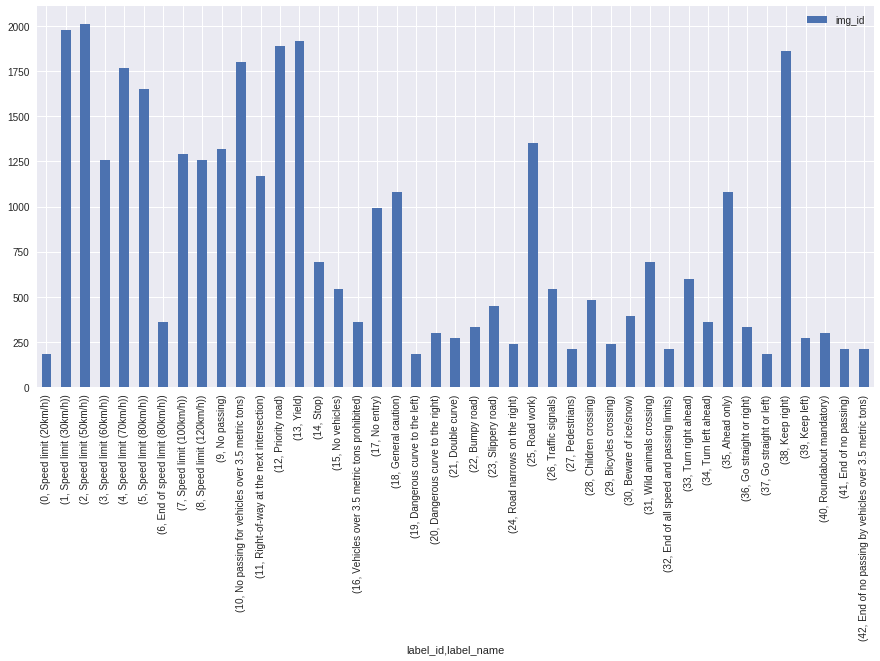

In [0]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_group_by_label_count.plot(kind='bar', figsize=(15, 7))

This confirms the significant class imbalance we observed earlier. At this stage we will not attempt to address it.

#### Training Set Image Visualization

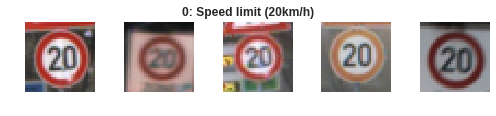

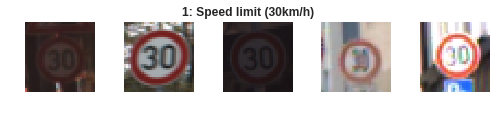

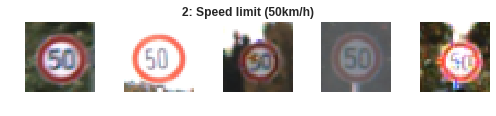

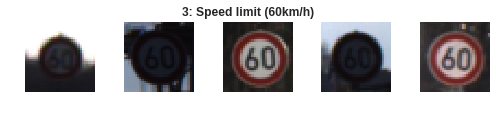

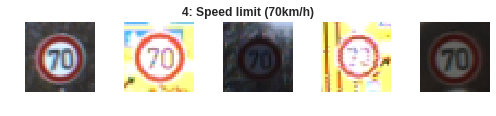

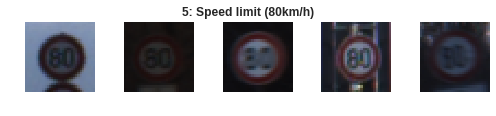

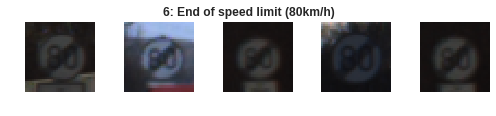

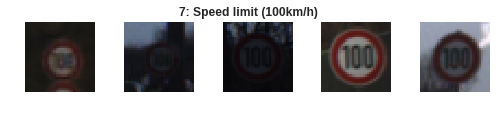

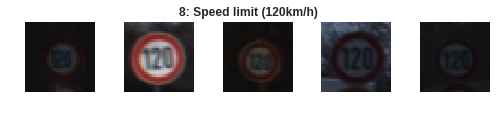

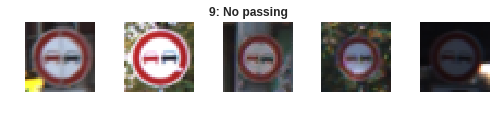

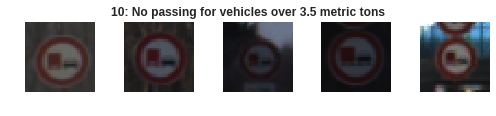

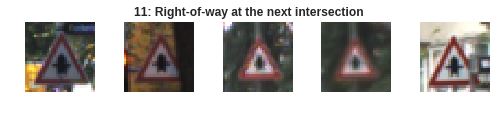

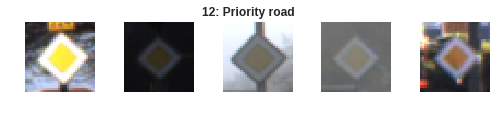

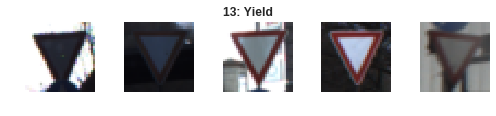

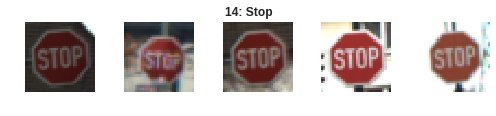

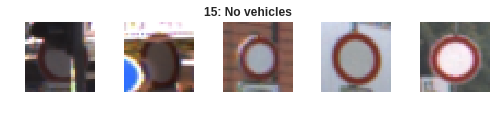

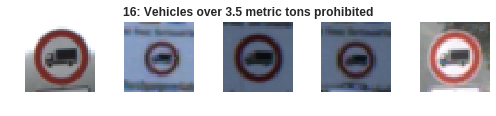

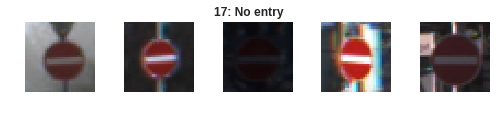

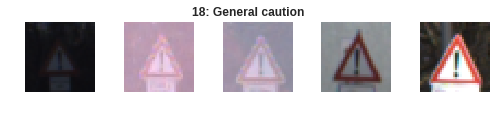

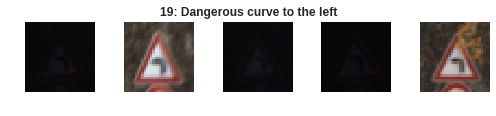

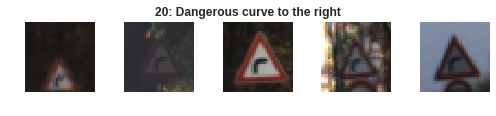

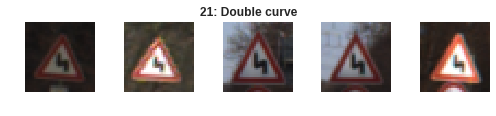

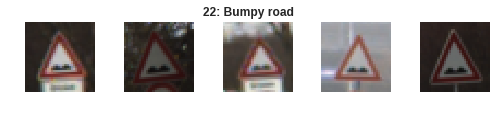

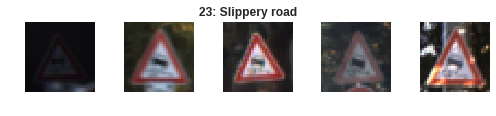

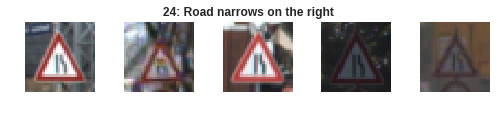

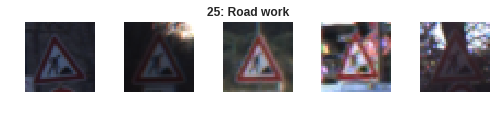

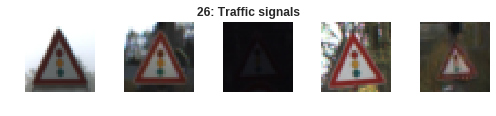

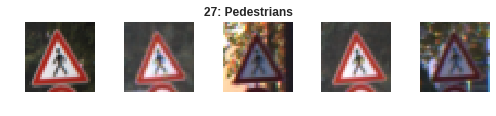

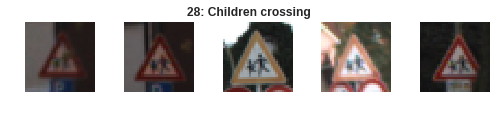

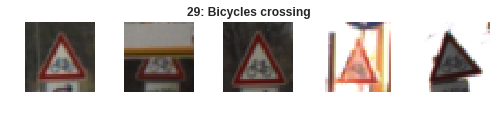

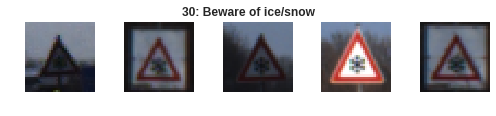

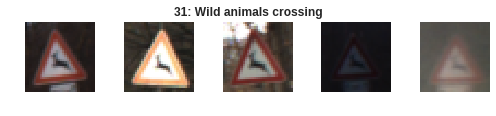

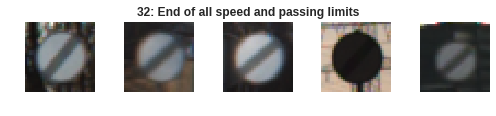

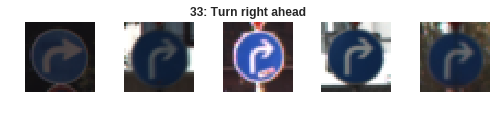

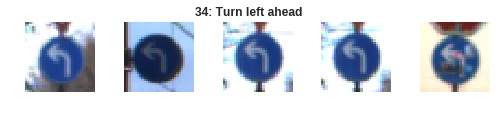

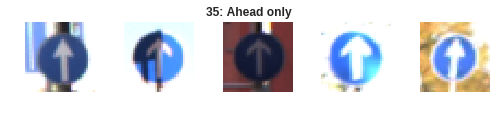

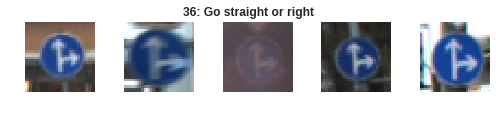

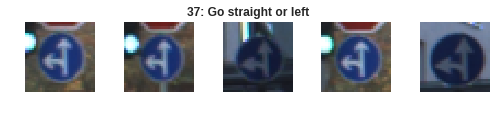

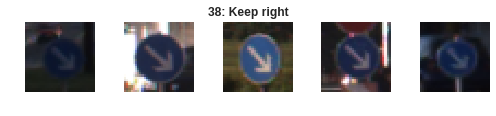

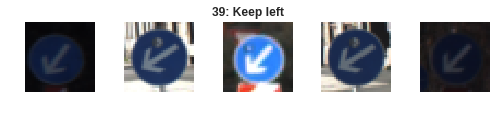

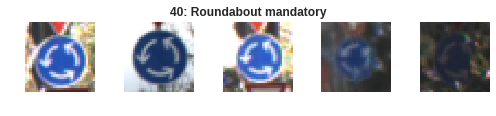

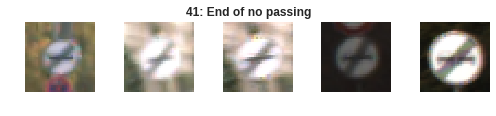

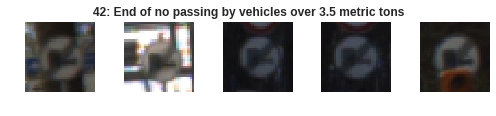

In [0]:
# Let's plot images from each of these classes
X_train_group_by_label = X_train_id_to_label.groupby(["label_id", "label_name"])
img_per_class = 5

show_random_dataset_images(X_train_group_by_label, X_train)    

#### Group Images In Validation Set

In [0]:
# Create a data frame whereby we index image id  with label
X_valid_id_to_label = group_img_id_to_lbl(y_valid, sign_names)

# Let's print a few of those mappings now
X_valid_id_to_label.head(n=3)

img_id  label_id         label_name
0       0        41  End of no passing
1       1        41  End of no passing
2       2        41  End of no passing

In [0]:
# We should group by label id to understand the distribution
X_valid_group_by_label_count = group_img_id_to_lb_count(X_valid_id_to_label)
X_valid_group_by_label_count.head(n=3)

img_id
label_id label_name                  
0        Speed limit (20km/h)      30
1        Speed limit (30km/h)     240
2        Speed limit (50km/h)     240

#### Validation Set Distribution Visualization

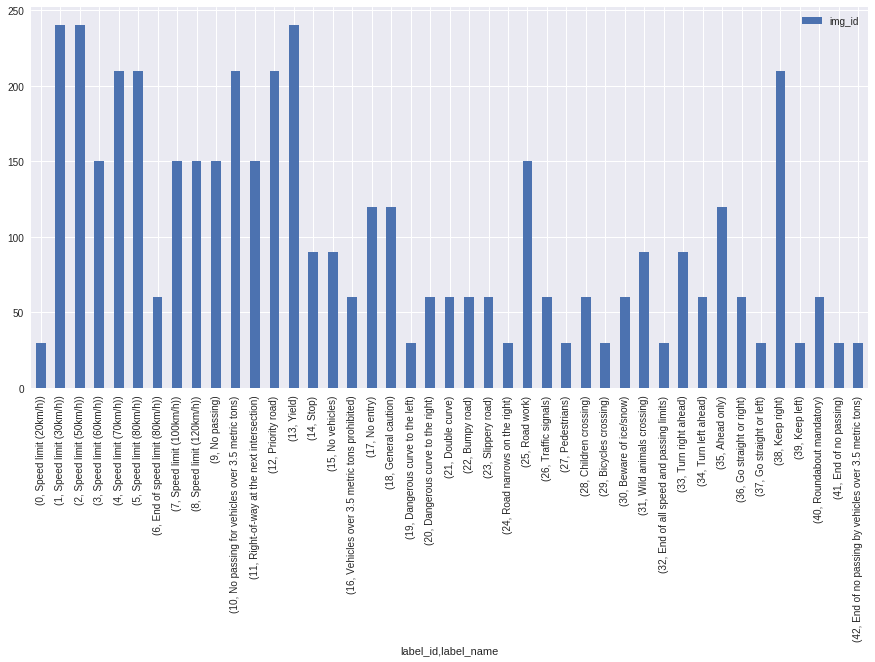

In [0]:
# Now count the number of images for each class and plot the results so that we understand the distribution
X_valid_group_by_label_count.plot(kind='bar', figsize=(15, 7))

We also observe significant imbalance in the validation set. This is honestly less of a problem as we do not train our data on it.

#### Validation Set Images Visualization

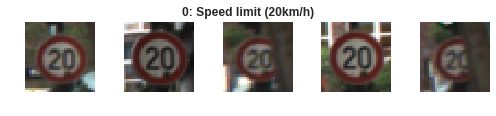

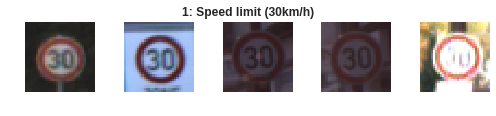

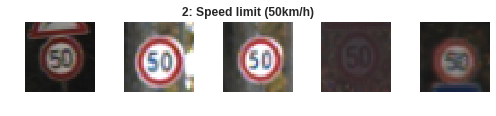

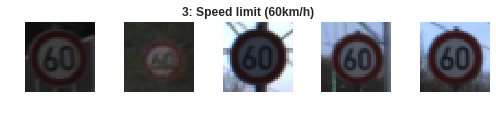

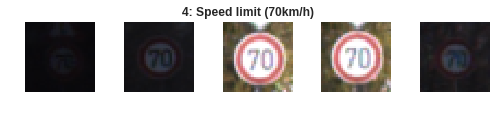

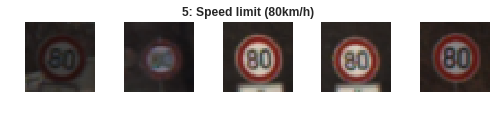

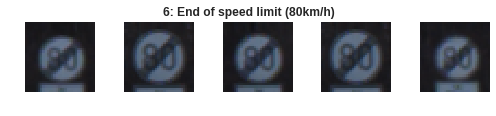

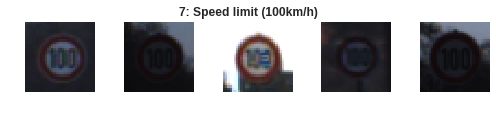

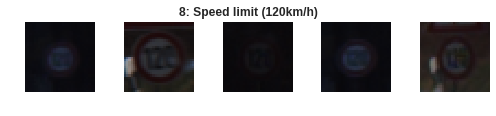

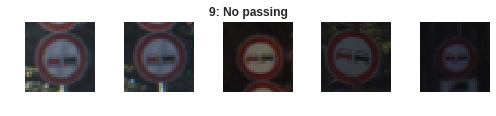

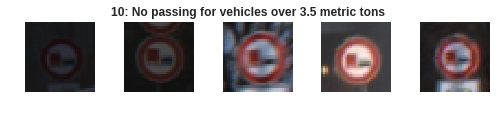

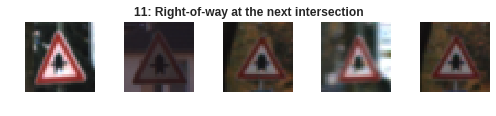

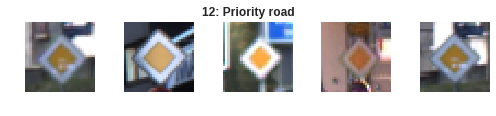

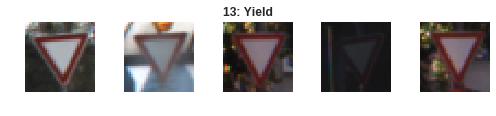

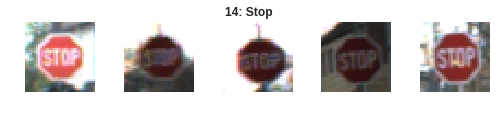

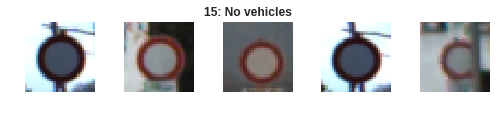

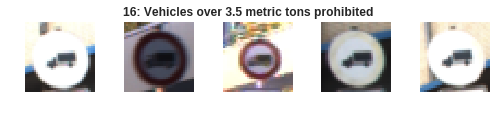

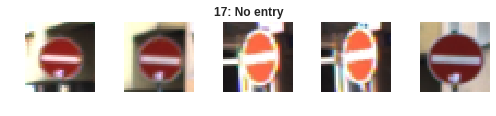

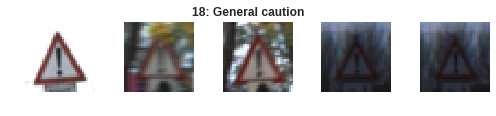

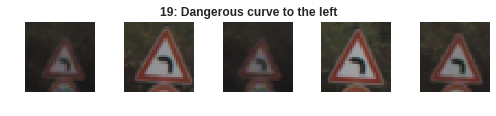

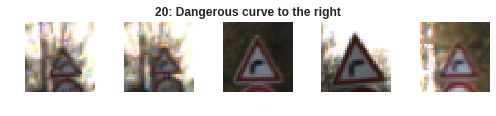

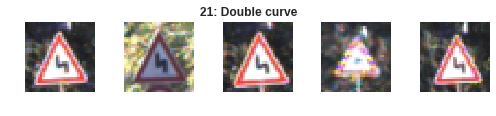

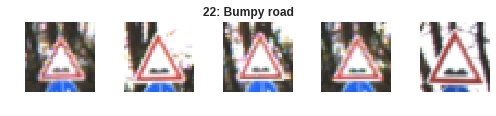

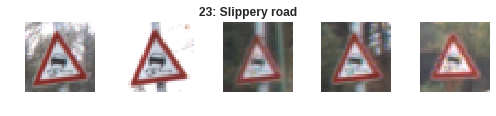

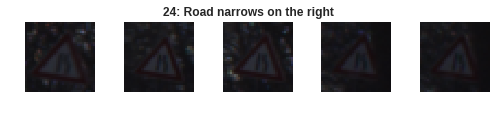

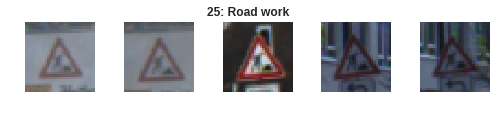

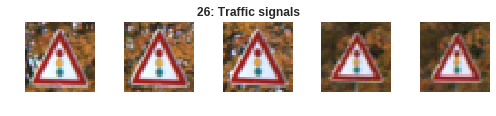

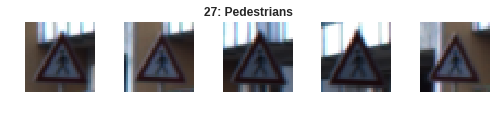

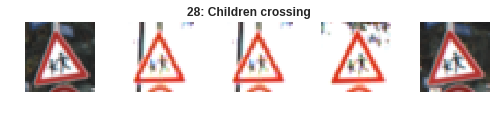

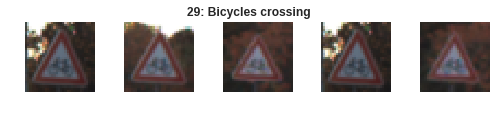

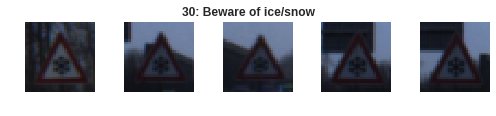

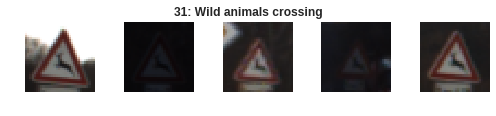

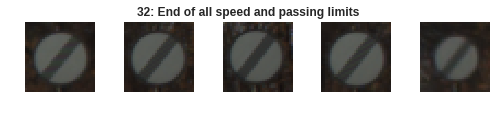

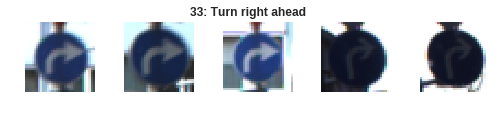

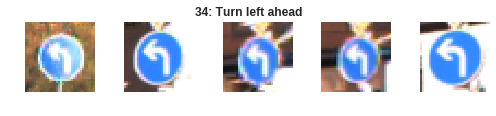

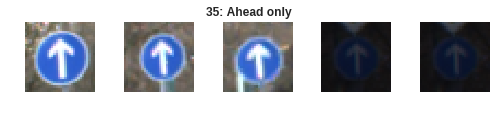

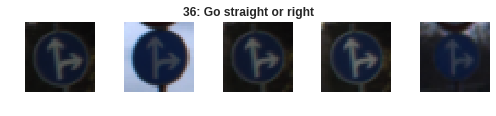

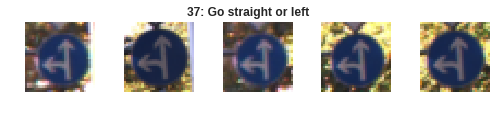

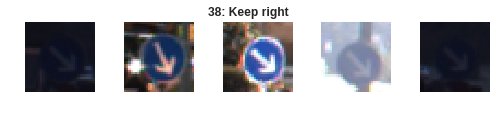

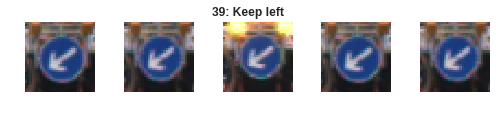

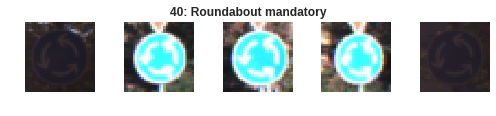

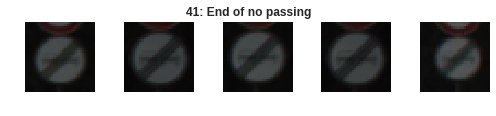

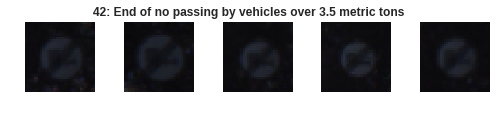

In [0]:
# Let's plot images from each of these classes
X_valid_group_by_label = X_valid_id_to_label.groupby(["label_id", "label_name"])

show_random_dataset_images(X_valid_group_by_label, X_valid)

The validation set seems to suffer from the same problems as the training set, where some images are extremely dark.

### Create a sample set

As we have over 30 thousand images, we do not want to try every model on the whole dataset as this would be extremely time consuming. Instead, we create _sample_ datasets for training and validation, where we copy a percentage P of both dataset.

In [0]:
X_sample_train, y_sample_train = create_sample_set(X_train_group_by_label, X_train, y_train, pct=0.33)
print("Sample training images dimensions={0}, labels dimensions={1}".format(X_sample_train.shape, y_sample_train.shape))

X_sample_valid, y_sample_valid = create_sample_set(X_valid_group_by_label, X_valid, y_valid, pct=0.33)
print("Sample validation images dimensions={0}, labels dimensions={1}".format(X_sample_valid.shape, y_sample_valid.shape))

Sample training images dimensions=(11464, 32, 32, 3), labels dimensions=(11464,)
Sample validation images dimensions=(1427, 32, 32, 3), labels dimensions=(1427,)


We can see that some images are very dark, and we should therefore look at applying a pre-processing step to brighten them if possible.

----

# Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Data Pre-Processing

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Normalisation

In [0]:
# Normalise training set
X_train_normalised = normalise_images(X_train, X_train)

In [0]:
# Do the same for training and validation sets, using mean and standard deviation of training set
X_valid_normalised = normalise_images(X_valid, X_train) 
X_test_normalised = normalise_images(X_test, X_train) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


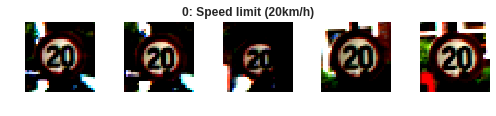

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


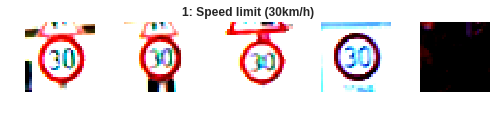

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


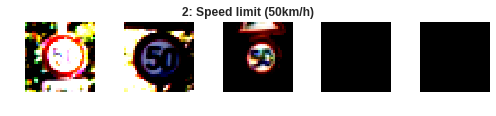

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


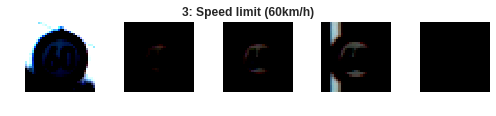

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


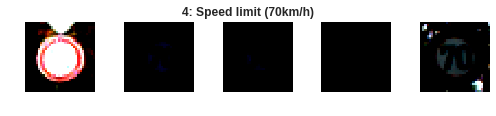

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


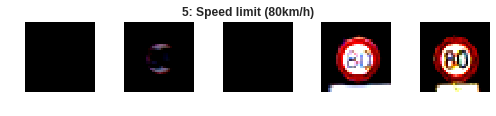

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


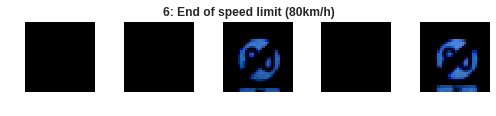

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


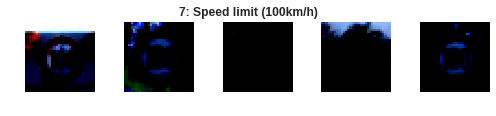

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


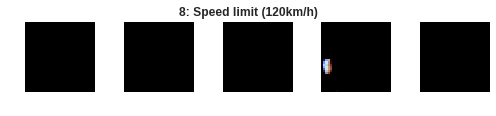

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


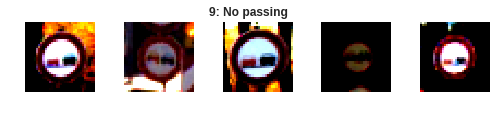

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


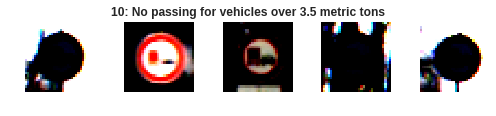

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


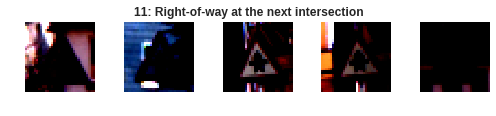

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


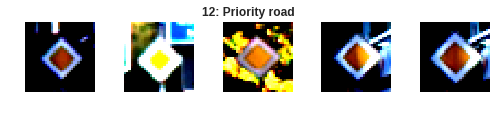

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


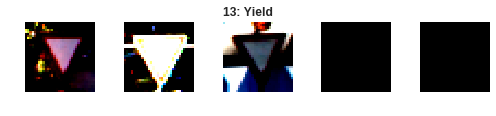

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


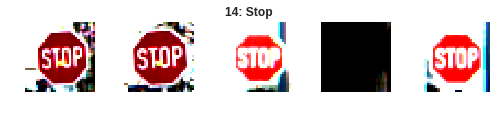

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


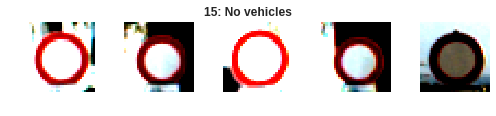

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


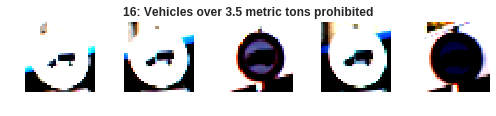

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


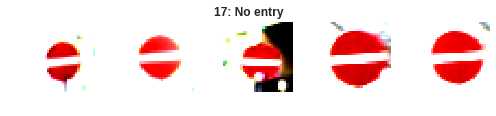

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


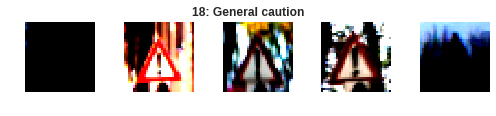

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


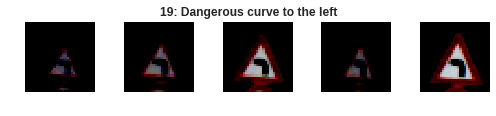

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


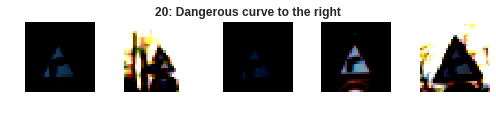

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


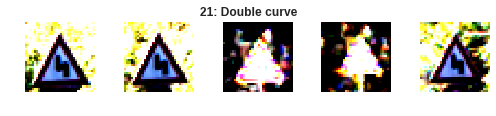

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


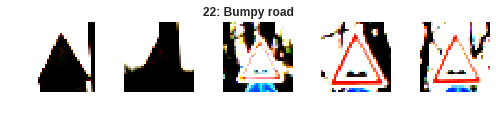

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


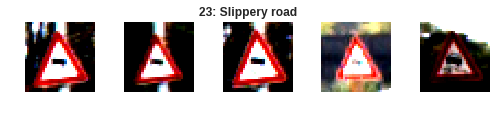

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


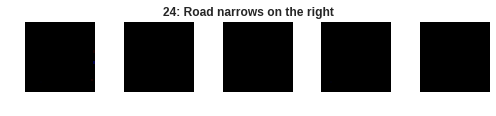

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


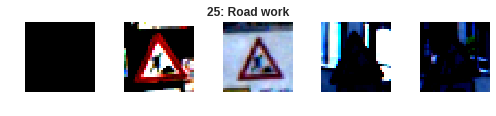

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


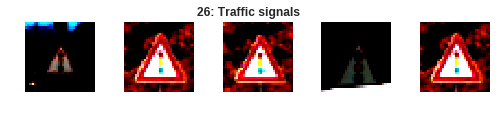

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


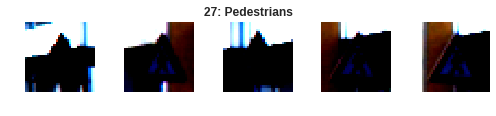

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


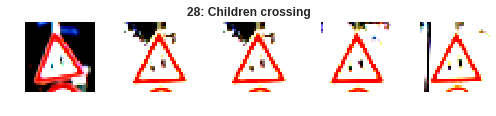

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


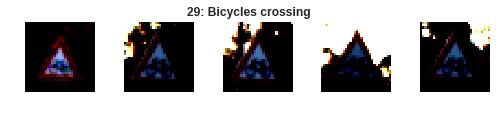

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


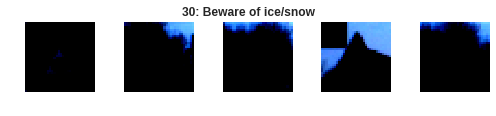

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


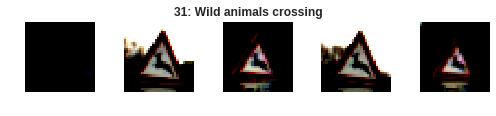

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


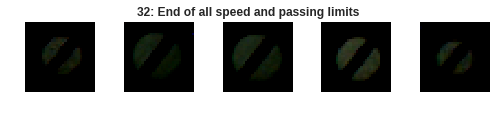

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


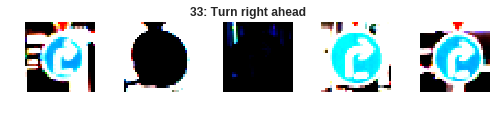

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


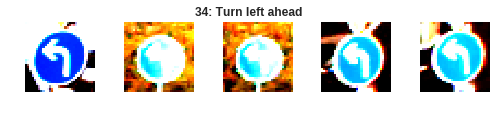

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


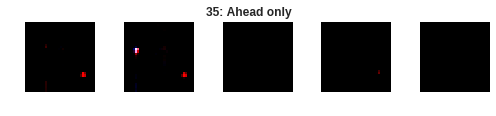

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


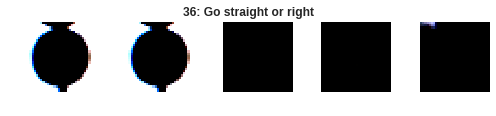

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


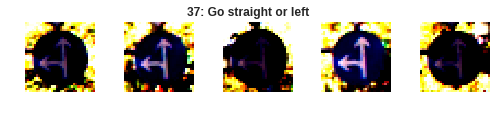

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


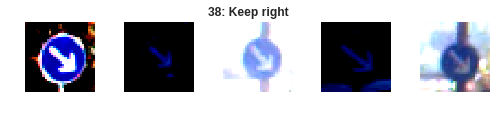

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


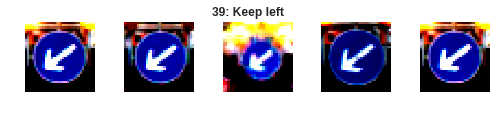

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


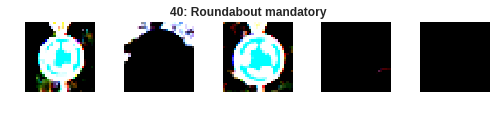

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


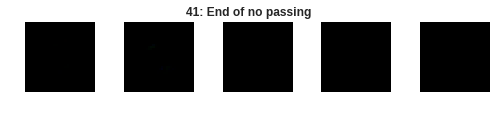

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


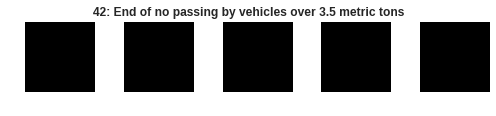

In [0]:
show_random_dataset_images(X_valid_group_by_label, X_valid_normalised)

### Grayscale

In [0]:
# Let's test our image graying features on training set
X_train_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train))) 
#show_random_dataset_images(X_train_group_by_label, X_train_grayscale)

We can see that grayscaling somewhat improves the visibility of the images, but some of them still remain very dark. At this stage we will not address this problem.

In [0]:
# Do the same on validation set
X_valid_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_valid))) 
#show_random_dataset_images(X_valid_group_by_label, X_valid_grayscale)

In [0]:
# Also grayscale test data
X_test_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_test))) 
#show_image_list(X_test_grayscale[10:13], y_test[10:13], "Gray image", cols=3, fig_size=(3, 3), show_ticks=False)

## Model Architectures

In this section, we will a configurable neural network architecture where the number of layers as well as filter sizes can be modified. But first, we set up the pipeline to enable us to achieve our goal.

### Configuration and Execution Pipeline

We define the steps necessary to build a training pipeline in Tensorflow. These are defined as classes to increase flexibility.

In [0]:
class ModelConfig:
    """
    ModelConfig is a utility class that stores important configuration option about our model
    """

    def __init__(self, model, name, input_img_dimensions, conv_layers_config, fc_output_dims, output_classes, dropout_keep_pct):
        self.model = model
        self.name=name
        self.input_img_dimensions = input_img_dimensions
        
        # Determines the wxh dimension of filters, the starting depth (increases by x2 at every layer) 
        # and how many convolutional layers the network has
        self.conv_filter_size = conv_layers_config[0]
        self.conv_depth_start = conv_layers_config[1]
        self.conv_layers_count = conv_layers_config[2]


        self.fc_output_dims = fc_output_dims 
        self.output_classes = output_classes

        # Try with different values for drop out at convolutional and fully connected layers
        self.dropout_conv_keep_pct = dropout_keep_pct[0]
        self.dropout_fc_keep_pct = dropout_keep_pct[1]

In [0]:
class ModelExecutor:
    """
    ModelExecutor is responsible for executing the supplied model
    """
    def __init__(self, model_config, learning_rate=0.001):
        self.model_config = model_config
        self.learning_rate = learning_rate
    
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope( self.model_config.name ) as scope:
                # Create Model operations
                self.create_model_operations()

                # Create a saver to persist the results of execution
                self.saver = tf.train.Saver()
    
    def create_placeholders(self):
        """
        Defining our placeholder variables:
            - x, y
            - one_hot_y
            - dropout placeholders
        """

        # e.g. 32 * 32 * 3
        input_dims = self.model_config.input_img_dimensions
        self.x = tf.placeholder(tf.float32, (None, input_dims[0], input_dims[1], input_dims[2]), name="{0}_x".format(self.model_config.name))
        self.y = tf.placeholder(tf.int32, (None), name="{0}_y".format(self.model_config.name))
        self.one_hot_y = tf.one_hot(self.y, self.model_config.output_classes)

        self.dropout_placeholder_conv = tf.placeholder(tf.float32)
        self.dropout_placeholder_fc = tf.placeholder(tf.float32)

    
    def create_model_operations(self):
        """
        Sets up all operations needed to execute run deep learning pipeline
        """

        # First step is to set our x, y, etc
        self.create_placeholders()

        cnn = self.model_config.model

        # Build the network -  TODO: pass the configuration in the future
        self.logits = cnn(self.x, self.model_config, self.dropout_placeholder_conv, self.dropout_placeholder_fc)
        # Obviously, using softmax as the activation function for final layer
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        # Combined all the losses across batches
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        # What method do we use to reduce our loss?
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        # What do we really do in a training operation then? Answer: we attempt to reduce the loss using our chosen optimizer
        self.training_operation = self.optimizer.minimize(self.loss_operation)

        # Get the top prediction for model against labels and check whether they match
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        # Compute accuracy at batch level
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))

        # compute what the prediction would be, when we don't have matching label
        self.prediction = tf.argmax(self.logits, 1)
        # Registering our top 5 predictions
        self.top5_predictions = tf.nn.top_k(tf.nn.softmax(self.logits), k=5, sorted=True, name=None)

        
    def evaluate_model(self, X_data, Y_data, batch_size):
        """
        Evaluates the model's accuracy and loss for the supplied dataset. 
        Naturally, Dropout is ignored in this case (i.e. we set dropout_keep_pct to 1.0)
        """
        
        num_examples = len(X_data)
        total_accuracy = 0.0
        total_loss = 0.0
        sess = tf.get_default_session()

        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            
            # Compute both accuracy and loss for this batch
            accuracy = sess.run(self.accuracy_operation, 
                                feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })
            loss = sess.run(self.loss_operation, feed_dict={
                                    self.dropout_placeholder_conv: 1.0,
                                    self.dropout_placeholder_fc: 1.0,
                                    self.x: batch_x, 
                                    self.y: batch_y
                                           })

            # Weighting accuracy by the total number of elements in batch
            total_accuracy += (accuracy * len(batch_x))        
            total_loss += (loss * len(batch_x))            

        # To produce a true mean accuracy over whole dataset
        return (total_accuracy / num_examples, total_loss / num_examples) 
    
    
    def train_model(self, X_train_features, X_train_labels, X_valid_features, y_valid_labels, batch_size=512, epochs=100, PRINT_FREQ=10):
        """
        Trains the model for the specified number of epochs supplied when creating the executor
        """

        # Create our array of metrics    
        training_metrics = np.zeros((epochs, 3))
        validation_metrics = np.zeros((epochs, 3))


        with tf.Session(graph = self.graph, config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:            
            
            sess.run(tf.global_variables_initializer())
            num_examples = len(X_train_features)


            print("Training {0} [epochs={1}, batch_size={2}]...\n".format(self.model_config.name, epochs, batch_size))

            for i in range(epochs):
                start = time.time()
                X_train, Y_train = shuffle(X_train_features, X_train_labels)
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                    sess.run(self.training_operation, feed_dict={
                        self.x: batch_x, 
                        self.y: batch_y, 
                        self.dropout_placeholder_conv: self.model_config.dropout_conv_keep_pct,
                        self.dropout_placeholder_fc: self.model_config.dropout_fc_keep_pct,

                    })

                end_training_time = time.time()
                training_duration = end_training_time - start

                #computing training accuracy
                training_accuracy, training_loss = self.evaluate_model(X_train_features, X_train_labels, batch_size)            


                # Computing validation accuracy 
                validation_accuracy, validation_loss = self.evaluate_model(X_valid_features, y_valid_labels, batch_size)


                end_epoch_time = time.time()            
                validation_duration = end_epoch_time - end_training_time   
                epoch_duration = end_epoch_time - start

                if i == 0 or (i+1) % PRINT_FREQ == 0:
                    print("[{0}]\ttotal={1:.3f}s | train: time={2:.3f}s, loss={3:.4f}, acc={4:.4f} | val: time={5:.3f}s, loss={6:.4f}, acc={7:.4f}".format(
                          i+1, epoch_duration, training_duration, training_loss, training_accuracy, 
                        validation_duration, validation_loss, validation_accuracy))

                training_metrics[i] = [training_duration, training_loss, training_accuracy]
                validation_metrics[i] = [validation_duration, validation_loss, validation_accuracy]

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            # Save the model
            self.saver.save(sess, model_file_name)
            print("Model {0} saved".format(model_file_name))

        return (training_metrics, validation_metrics, epoch_duration)
    
    def test_model(self, test_imgs, test_lbs, batch_size=512):
        """
        Evaluates the model with the test dataset and test labels
        Returns the tuple (test_accuracy, test_loss, duration)
        """

        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            
            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)

            start = time.time()
            (test_accuracy, test_loss) = self.evaluate_model(test_imgs, test_lbs, batch_size)
            duration = time.time() - start
            print("[{0} - Test Set]\ttime={1:.3f}s, loss={2:.4f}, acc={3:.4f}".format(self.model_config.name, duration, test_loss, test_accuracy))

        
        return (test_accuracy, test_loss, duration)
    
    def predict(self, imgs, top_5=False):
        """
        Returns the predictions associated with a bunch of images
        """
        preds = None
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            if top_5:
                preds = sess.run(self.top5_predictions, feed_dict={
                        self.x: imgs,
                        self.dropout_placeholder_conv: 1.0,
                        self.dropout_placeholder_fc: 1.0
                    })
            else:
                preds = sess.run(self.prediction, feed_dict={
                    self.x: imgs,
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })
    
        return preds
    
    def show_conv_feature_maps(self, img, conv_layer_idx=0, activation_min=-1, activation_max=-1 ,
                               plt_num=1, fig_size=(15, 15), title_y_pos=1.0):
        """
        Shows the resulting feature maps at a given convolutional level for a SINGLE image
        """
        #s = tf.train.Saver()
        with tf.Session(graph = self.graph) as sess:
            # Never forget to re-initialise the variables
            tf.global_variables_initializer()
            #tf.reset_default_graph()

            model_file_name = "{0}{1}.chkpt".format(models_path, self.model_config.name)
            self.saver.restore(sess, model_file_name)
            
            # Run a prediction
            preds = sess.run(self.prediction, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                    self.dropout_placeholder_conv: 1.0,
                    self.dropout_placeholder_fc: 1.0
                })

            
            var_name = "{0}/conv_{1}_relu:0".format(self.model_config.name, conv_layer_idx)
            print("Fetching tensor: {0}".format(var_name))
            conv_layer = tf.get_default_graph().get_tensor_by_name(var_name)
            
            activation = sess.run(conv_layer, feed_dict={
                            self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                            self.dropout_placeholder_conv: 1.0,
                            self.dropout_placeholder_fc: 1.0
                            })
            featuremaps = activation.shape[-1]
            # (1, 13, 13, 64)
            print("Shape of activation layer: {0}".format(activation.shape))
            
            #fix the number of columns
            cols = 8
            rows = featuremaps // cols
            fig, axes = plt.subplots(rows, cols, figsize=fig_size)
            k = 0
            for i in range(0, rows):
                for j in range(0, cols):
                    ax = axes[i, j]
                    featuremap = k

                    if activation_min != -1 & activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
                    elif activation_max != -1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
                    elif activation_min !=-1:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
                    else:
                        ax.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
                    
                    ax.axis("off")
                    k += 1
            
            fig.suptitle("Feature Maps at layer: {0}".format(conv_layer), fontsize=12, fontweight='bold', y=title_y_pos)
            fig.tight_layout()
            plt.show()
                            

#### EdLeNet

We implement simple variant LeNet by Yann Le Cun, comically named *EdLeNet*. We make the network highly configurable so that we can assess its different variants and determine which one provides the most accuracy.

In [0]:
from tensorflow.contrib.layers import flatten

def EdLeNet(x, mc, dropout_conv_pct, dropout_fc_pct):
    """
    A variant of LeNet created by Yann Le Cun
    The second parameter, which is encapsulates model configuration, enables varying the convolution filter sizes 
    as well as the number of fully connected layers and their output dimensions.
    The third and fourth parameters represent dropout placeholders for convolutional and fully connected layers respectively
    """
    
    # Used for randomly definining weights and biases
    mu = 0
    sigma = 0.1
    
    prev_conv_layer = x
    conv_depth = mc.conv_depth_start
    conv_input_depth = mc.input_img_dimensions[-1]
   
    print("[EdLeNet] Building neural network [conv layers={0}, conv filter size={1}, conv start depth={2}, fc layers={3}]".format(
        mc.conv_layers_count, mc.conv_filter_size, conv_depth, len(mc.fc_output_dims)))
    
    for i in range(0, mc.conv_layers_count):
        # layer depth grows exponentially
        conv_output_depth = conv_depth * (2 ** (i))
        conv_W = tf.Variable(tf.truncated_normal(shape=(mc.conv_filter_size, mc.conv_filter_size, conv_input_depth, conv_output_depth), 
                                              mean = mu, stddev = sigma))
        conv_b = tf.Variable(tf.zeros(conv_output_depth))
        
        conv_output = tf.nn.conv2d(prev_conv_layer, conv_W, strides=[1, 1, 1, 1], padding='VALID', name="conv_{0}".format(i)) + conv_b
        conv_output = tf.nn.relu(conv_output, name="conv_{0}_relu".format(i))
        # Traditional max 2x2 pool 
        conv_output = tf.nn.max_pool(conv_output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        # Apply dropout - even at the conv level
        conv_output = tf.nn.dropout(conv_output, dropout_conv_pct) 
        
        # Setting our loop variables accordingly
        prev_conv_layer = conv_output
        conv_input_depth = conv_output_depth

    
    # Flatten results of second convolutional layer so that it can be supplied to fully connected layer
    fc0   = flatten(prev_conv_layer)
    
    # Now creating our fully connected layers
    prev_layer = fc0
    for output_dim in mc.fc_output_dims:
        fcn_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], output_dim), 
                                                 mean = mu, stddev = sigma))
        fcn_b  = tf.Variable(tf.zeros(output_dim))
        
        prev_layer   = tf.nn.dropout(tf.nn.relu(tf.matmul(prev_layer, fcn_W) + fcn_b), dropout_fc_pct)

    
    # Final layer (Fully Connected)
    fc_final_W  = tf.Variable(tf.truncated_normal(shape=(prev_layer.get_shape().as_list()[-1], mc.output_classes), 
                                                  mean = mu, stddev = sigma))
    fc_final_b  = tf.Variable(tf.zeros(mc.output_classes))
    logits = tf.matmul(prev_layer, fc_final_W) + fc_final_b
    
    return logits

## Train, Validate and Test the Model

### Non-Normalised Images

Let's begin with color and grayscale non-normalised images, changing the feature size

#### Color Sample Set

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Sample", [32, 32, 3], [3, 16, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_5x5_Color_Sample", [32, 32, 3], [5, 16, 2], [120, 84], n_classes, [1.0, 1.0])
mc_7x7 = ModelConfig(EdLeNet, "EdLeNet_7x7_Color_Sample", [32, 32, 3], [7, 16, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_c_sample_3x3 = ModelExecutor(mc_3x3)
me_c_sample_5x5 = ModelExecutor(mc_5x5)
me_c_sample_7x7 = ModelExecutor(mc_7x7)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=16, fc layers=2]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=16, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=7, conv start depth=16, fc layers=2]


In [0]:
(c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics, c_sample_3x3_duration) = me_c_sample_3x3.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_3x3_ts_accuracy, c_sample_3x3_ts_loss, c_sample_3x3_ts_duration) =  me_c_sample_3x3.test_model(X_test, y_test)

Training EdLeNet_3x3_Color_Sample [epochs=50, batch_size=512]...

[1]	total=1.365s | train: time=0.790s, loss=3.6496, acc=0.0701 | val: time=0.574s, loss=3.6252, acc=0.0876
[10]	total=0.984s | train: time=0.504s, loss=0.5073, acc=0.8613 | val: time=0.479s, loss=1.4035, acc=0.6804
[20]	total=0.981s | train: time=0.498s, loss=0.1369, acc=0.9665 | val: time=0.484s, loss=1.3635, acc=0.7680
[30]	total=0.973s | train: time=0.497s, loss=0.0387, acc=0.9931 | val: time=0.476s, loss=1.5897, acc=0.8024
[40]	total=0.967s | train: time=0.494s, loss=0.0618, acc=0.9852 | val: time=0.473s, loss=1.8848, acc=0.8073
[50]	total=0.987s | train: time=0.501s, loss=0.0038, acc=1.0000 | val: time=0.486s, loss=1.7623, acc=0.8402
Model ./models/EdLeNet_3x3_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_3x3_Color_Sample.chkpt
[EdLeNet_3x3_Color_Sample - Test Set]	time=0.554s, loss=1.5967, acc=0.8305


In [0]:
(c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_5x5_duration) = me_c_sample_5x5.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_5x5_ts_accuracy, c_sample_5x5_ts_loss, c_sample_5x5_ts_duration) =  me_c_sample_5x5.test_model(X_test, y_test)

Training EdLeNet_5x5_Color_Sample [epochs=50, batch_size=512]...

[1]	total=1.234s | train: time=0.710s, loss=4.3760, acc=0.1196 | val: time=0.523s, loss=4.5097, acc=0.1226
[10]	total=0.849s | train: time=0.430s, loss=0.3608, acc=0.8986 | val: time=0.419s, loss=1.6467, acc=0.7015
[20]	total=0.847s | train: time=0.431s, loss=0.0575, acc=0.9898 | val: time=0.416s, loss=1.7053, acc=0.7758
[30]	total=0.847s | train: time=0.430s, loss=0.0206, acc=0.9972 | val: time=0.417s, loss=1.8126, acc=0.7870
[40]	total=0.854s | train: time=0.429s, loss=0.0060, acc=0.9998 | val: time=0.425s, loss=2.1500, acc=0.7968
[50]	total=0.856s | train: time=0.439s, loss=0.0027, acc=1.0000 | val: time=0.418s, loss=2.3164, acc=0.7905
Model ./models/EdLeNet_5x5_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_5x5_Color_Sample.chkpt
[EdLeNet_5x5_Color_Sample - Test Set]	time=0.505s, loss=2.2114, acc=0.8097


In [0]:
(c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_7x7_duration) = me_c_sample_7x7.train_model(X_sample_train, y_sample_train, X_sample_valid, y_sample_valid, epochs=50)
(c_sample_7x7_ts_accuracy, c_sample_7x7_ts_loss, c_sample_7x7_ts_duration) =  me_c_sample_7x7.test_model(X_test, y_test)

Training EdLeNet_7x7_Color_Sample [epochs=50, batch_size=512]...

[1]	total=1.137s | train: time=0.646s, loss=4.0800, acc=0.0850 | val: time=0.491s, loss=4.1662, acc=0.0848
[10]	total=0.773s | train: time=0.394s, loss=0.7201, acc=0.8029 | val: time=0.378s, loss=1.4960, acc=0.6720
[20]	total=0.781s | train: time=0.391s, loss=0.1372, acc=0.9634 | val: time=0.390s, loss=1.3204, acc=0.7680
[30]	total=0.779s | train: time=0.394s, loss=0.0368, acc=0.9947 | val: time=0.385s, loss=1.3138, acc=0.8087
[40]	total=0.781s | train: time=0.396s, loss=0.0127, acc=0.9992 | val: time=0.385s, loss=1.5188, acc=0.8220
[50]	total=0.786s | train: time=0.394s, loss=0.0050, acc=1.0000 | val: time=0.392s, loss=1.6555, acc=0.8283
Model ./models/EdLeNet_7x7_Color_Sample.chkpt saved
INFO:tensorflow:Restoring parameters from ./models/EdLeNet_7x7_Color_Sample.chkpt
[EdLeNet_7x7_Color_Sample - Test Set]	time=0.462s, loss=2.4186, acc=0.7913


The 3x3 model has much lower loss than the other two on the validation and test sets. We may be tempted to exclusively focus on it, but instead we will run the 3x3 and 5x5 models side by side, as the 7x7 one seems to produce the worst results.

Length of axis: (2,)


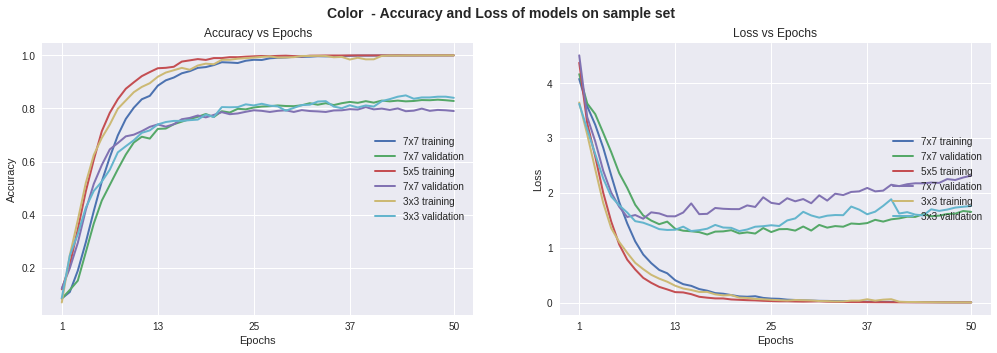

In [0]:
metrics_arr = [c_sample_7x7_tr_metrics, c_sample_7x7_val_metrics, c_sample_5x5_tr_metrics, c_sample_5x5_val_metrics, c_sample_3x3_tr_metrics, c_sample_3x3_val_metrics]
lbs = ["7x7 training", "7x7 validation", "5x5 training", "7x7 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models on sample set"
                    , fig_size=(17, 5))     

#### Color Full Dataset

We now run the 3x3 and 5x5 models on the full color dataset. We also took the liberty to increase the depth of our convolutional layers as we have observed better information starting at 32, rather than 16.

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Full_Color_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_c_3x3 = ModelExecutor(mc_3x3)
me_c_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(c_3x3_tr_metrics, c_3x3_val_metrics, c_3x3_duration) = me_c_3x3.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_3x3_ts_accuracy, c_3x3_ts_loss, c_3x3_ts_duration) =  me_c_3x3.test_model(X_test, y_test)

Training EdLeNet_Full_Color_3x3 [epochs=100, batch_size=512]...

[1]	total=4.968s | train: time=2.694s, loss=2.5855, acc=0.3506 | val: time=2.274s, loss=2.9613, acc=0.2785
[10]	total=4.528s | train: time=2.359s, loss=0.0554, acc=0.9866 | val: time=2.170s, loss=0.7453, acc=0.8798
[20]	total=4.530s | train: time=2.358s, loss=0.0075, acc=0.9988 | val: time=2.172s, loss=0.8986, acc=0.8995
[30]	total=4.638s | train: time=2.444s, loss=0.0007, acc=1.0000 | val: time=2.193s, loss=1.1020, acc=0.9052
[40]	total=4.551s | train: time=2.360s, loss=0.0003, acc=1.0000 | val: time=2.192s, loss=1.2217, acc=0.9045
[50]	total=4.542s | train: time=2.353s, loss=0.0054, acc=0.9994 | val: time=2.189s, loss=0.7234, acc=0.9254
[60]	total=4.556s | train: time=2.367s, loss=0.0008, acc=1.0000 | val: time=2.189s, loss=0.8769, acc=0.9306
[70]	total=4.544s | train: time=2.361s, loss=0.0003, acc=1.0000 | val: time=2.183s, loss=0.9611, acc=0.9299
[80]	total=4.529s | train: time=2.355s, loss=0.0002, acc=1.0000 | val: t

In [0]:
(c_5x5_tr_metrics, c_5x5_val_metrics, c_5x5_duration) = me_c_5x5.train_model(X_train, y_train, X_valid, y_valid, epochs=100)
(c_5x5_ts_accuracy, c_5x5_ts_loss, c_5x5_ts_duration) =  me_c_5x5.test_model(X_test, y_test)

Training EdLeNet_Full_Color_5x5 [epochs=100, batch_size=512]...

[1]	total=4.360s | train: time=2.314s, loss=3.7845, acc=0.2493 | val: time=2.046s, loss=4.4299, acc=0.2311
[10]	total=4.056s | train: time=2.091s, loss=0.1533, acc=0.9566 | val: time=1.965s, loss=1.1347, acc=0.8025
[20]	total=4.035s | train: time=2.084s, loss=0.0189, acc=0.9959 | val: time=1.951s, loss=1.1707, acc=0.8583
[30]	total=4.047s | train: time=2.091s, loss=0.0302, acc=0.9904 | val: time=1.956s, loss=1.4010, acc=0.8558
[40]	total=4.027s | train: time=2.089s, loss=0.0028, acc=0.9996 | val: time=1.938s, loss=1.2952, acc=0.8878
[50]	total=4.142s | train: time=2.176s, loss=0.0003, acc=1.0000 | val: time=1.965s, loss=1.5630, acc=0.8880
[60]	total=4.137s | train: time=2.184s, loss=0.0002, acc=1.0000 | val: time=1.953s, loss=1.6705, acc=0.8887
[70]	total=4.055s | train: time=2.086s, loss=0.0001, acc=1.0000 | val: time=1.969s, loss=1.7471, acc=0.8891
[80]	total=4.030s | train: time=2.078s, loss=0.0001, acc=1.0000 | val: t

Length of axis: (2,)


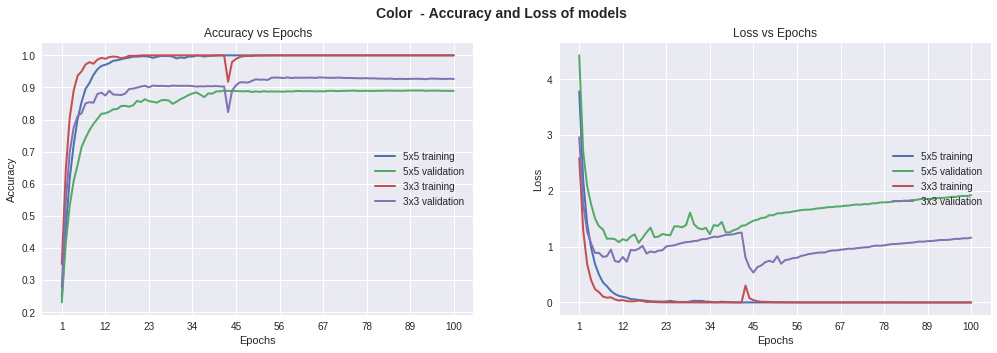

In [0]:
metrics_arr = [c_5x5_tr_metrics, c_5x5_val_metrics, c_3x3_tr_metrics, c_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color  - Accuracy and Loss of models"
                    , fig_size=(17, 5))     

Interesting, the 5x5 model is the one that shows the most overfit, and produces significantly higher losses than the 3x3 model, which manages to approach 93% accuracy on both validation and test sets, while not quite getting there. This could be due to the fact that we have a deeper network that uses less coarse convolutions and therefore is able to extract more features. We are next going to test the model on grayscale images.

#### Grayscale Full Dataset

In [0]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_grayscale = np.reshape(X_train_grayscale, (X_train_grayscale.shape[0], 32, 32, 1))
X_valid_grayscale = np.reshape(X_valid_grayscale, (X_valid_grayscale.shape[0], 32, 32, 1))
X_test_grayscale = np.reshape(X_test_grayscale, (X_test_grayscale.shape[0], 32, 32, 1))

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_g_3x3 = ModelExecutor(mc_3x3)
me_g_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(g_3x3_tr_metrics, g_3x3_val_metrics, g_3x3_duration) = me_g_3x3.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_3x3_ts_accuracy, g_3x3_ts_loss, g_3x3_ts_duration) =  me_g_3x3.test_model(X_test_grayscale, y_test)

Training EdLeNet_Grayscale_3x3 [epochs=100, batch_size=512]...

[1]	total=4.497s | train: time=2.469s, loss=2.8642, acc=0.2763 | val: time=2.028s, loss=3.1686, acc=0.2533
[10]	total=4.162s | train: time=2.220s, loss=0.0853, acc=0.9786 | val: time=1.943s, loss=0.7754, acc=0.8701
[20]	total=4.146s | train: time=2.215s, loss=0.0263, acc=0.9940 | val: time=1.931s, loss=0.7862, acc=0.9005
[30]	total=4.149s | train: time=2.215s, loss=0.0040, acc=0.9995 | val: time=1.934s, loss=0.7215, acc=0.9263
[40]	total=4.166s | train: time=2.223s, loss=0.0005, acc=1.0000 | val: time=1.943s, loss=0.8516, acc=0.9281
[50]	total=4.158s | train: time=2.219s, loss=0.0003, acc=1.0000 | val: time=1.939s, loss=0.9424, acc=0.9268
[60]	total=4.151s | train: time=2.217s, loss=0.0001, acc=1.0000 | val: time=1.934s, loss=0.9921, acc=0.9268
[70]	total=4.155s | train: time=2.214s, loss=0.0001, acc=1.0000 | val: time=1.940s, loss=1.0557, acc=0.9254
[80]	total=4.152s | train: time=2.219s, loss=0.0001, acc=1.0000 | val: ti

In [0]:
(g_5x5_tr_metrics, g_5x5_val_metrics, g_5x5_duration) = me_g_5x5.train_model(X_train_grayscale, y_train, X_valid_grayscale, y_valid, epochs=100)
(g_5x5_ts_accuracy, g_5x5_ts_loss, g_5x5_ts_duration) =  me_g_5x5.test_model(X_test_grayscale, y_test)

Training EdLeNet_Grayscale_5x5 [epochs=100, batch_size=512]...

[1]	total=3.739s | train: time=2.071s, loss=2.6905, acc=0.3464 | val: time=1.668s, loss=3.1079, acc=0.2880
[10]	total=3.509s | train: time=1.918s, loss=0.0470, acc=0.9896 | val: time=1.591s, loss=0.8813, acc=0.8633
[20]	total=3.518s | train: time=1.917s, loss=0.0183, acc=0.9954 | val: time=1.601s, loss=1.1696, acc=0.8744
[30]	total=3.420s | train: time=1.821s, loss=0.0019, acc=0.9999 | val: time=1.599s, loss=1.0472, acc=0.8991
[40]	total=3.508s | train: time=1.915s, loss=0.0003, acc=1.0000 | val: time=1.593s, loss=1.2054, acc=0.9007
[50]	total=3.429s | train: time=1.836s, loss=0.0002, acc=1.0000 | val: time=1.592s, loss=1.2927, acc=0.9005
[60]	total=3.428s | train: time=1.834s, loss=0.0001, acc=1.0000 | val: time=1.595s, loss=1.3686, acc=0.9018
[70]	total=3.422s | train: time=1.828s, loss=0.0001, acc=1.0000 | val: time=1.593s, loss=1.4268, acc=0.9016
[80]	total=3.426s | train: time=1.824s, loss=0.0000, acc=1.0000 | val: ti

Length of axis: (2,)


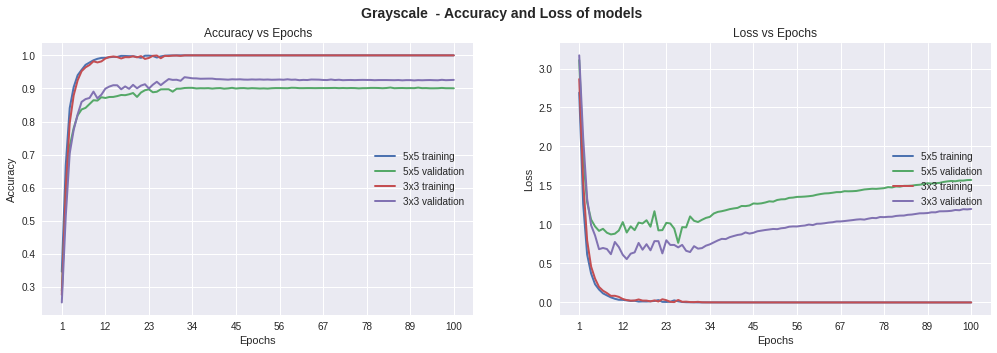

In [0]:
metrics_arr = [g_5x5_tr_metrics, g_5x5_val_metrics, g_3x3_tr_metrics, g_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale  - Accuracy and Loss of models"
                    , fig_size=(17, 5))     

Once again, the 3x3 model outperforms the 5x5 one on validation and test accuracy. We can see that both models' validation losses are _increasing_ as the training accuracy improves. This is a strong suggestion that overfitting is occuring.

### Normalised Images

We now assess the model on normnalised images, which should presumably allow faster convergence on both training and validation sets.

#### Color

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_c_norm_3x3 = ModelExecutor(mc_3x3)
me_c_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics, c_norm_3x3_duration) = me_c_norm_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_3x3_ts_accuracy, c_norm_3x3_ts_loss, c_norm_3x3_ts_duration) =  me_c_norm_3x3.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=5.358s | train: time=2.936s, loss=1.3089, acc=0.6161 | val: time=2.421s, loss=1.6560, acc=0.5417
[10]	total=5.003s | train: time=2.669s, loss=0.0270, acc=0.9924 | val: time=2.334s, loss=0.5381, acc=0.8871
[20]	total=5.005s | train: time=2.670s, loss=0.0030, acc=0.9996 | val: time=2.335s, loss=0.5364, acc=0.9077
[30]	total=5.010s | train: time=2.672s, loss=0.0006, acc=1.0000 | val: time=2.338s, loss=0.4587, acc=0.9249
[40]	total=5.016s | train: time=2.666s, loss=0.0002, acc=1.0000 | val: time=2.350s, loss=0.5122, acc=0.9224
[50]	total=5.024s | train: time=2.672s, loss=0.0001, acc=1.0000 | val: time=2.352s, loss=0.5375, acc=0.9227
[60]	total=5.021s | train: time=2.673s, loss=0.0001, acc=1.0000 | val: time=2.348s, loss=0.5711, acc=0.9218
[70]	total=5.022s | train: time=2.670s, loss=0.0000, acc=1.0000 | val: time=2.352s, loss=0.5979, acc=0.9220
[80]	total=5.017s | train: time=2.673s, loss=0.0000, acc=1.0000 | val: t

In [0]:
(c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_5x5_duration) = me_c_norm_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_5x5_ts_accuracy, c_norm_5x5_ts_loss, c_norm_5x5_ts_duration) =  me_c_norm_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=4.722s | train: time=2.541s, loss=0.8296, acc=0.7535 | val: time=2.181s, loss=1.2048, acc=0.6531
[10]	total=4.498s | train: time=2.395s, loss=0.0114, acc=0.9987 | val: time=2.103s, loss=0.4117, acc=0.9168
[20]	total=4.516s | train: time=2.404s, loss=0.0014, acc=0.9999 | val: time=2.112s, loss=0.4333, acc=0.9184
[30]	total=4.601s | train: time=2.495s, loss=0.0004, acc=1.0000 | val: time=2.106s, loss=0.4832, acc=0.9202
[40]	total=4.600s | train: time=2.420s, loss=0.0002, acc=1.0000 | val: time=2.180s, loss=0.5374, acc=0.9197
[50]	total=4.515s | train: time=2.397s, loss=0.0009, acc=1.0000 | val: time=2.118s, loss=0.4675, acc=0.9338
[60]	total=4.503s | train: time=2.403s, loss=0.0003, acc=1.0000 | val: time=2.100s, loss=0.5210, acc=0.9336
[70]	total=4.509s | train: time=2.403s, loss=0.0001, acc=1.0000 | val: time=2.106s, loss=0.5663, acc=0.9345
[80]	total=4.600s | train: time=2.487s, loss=0.0001, acc=1.0000 | val: t

Length of axis: (2,)


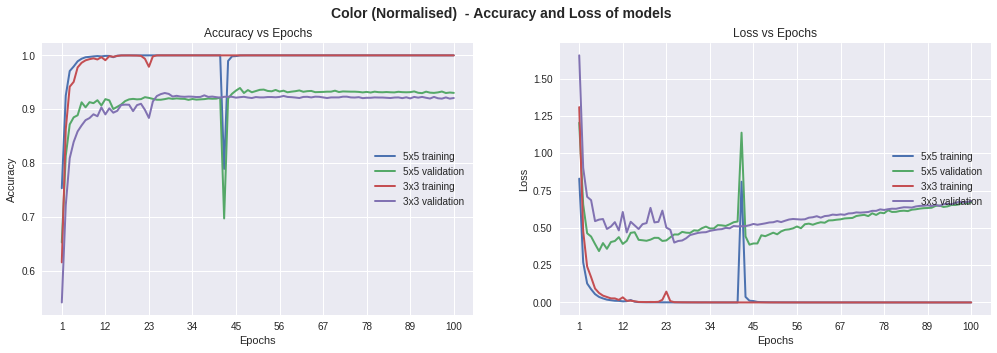

In [0]:
metrics_arr = [c_norm_5x5_tr_metrics, c_norm_5x5_val_metrics, c_norm_3x3_tr_metrics, c_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))     

Interesting, this time the roles are reversed: the 3x3 is performing worse on test and validation sets. I don't have a clear explanation, apart from overfitting happening much more quickly with the 3x3 model. We turn next to grayscale normalised images.

#### Grayscale

In [0]:
# Normalise grayscale images too
X_train_grayscale_normalised = normalise_images(X_train_grayscale, X_train_grayscale)
X_valid_grayscale_normalised = normalise_images(X_valid_grayscale, X_train_grayscale)
X_test_grayscale_normalised = normalise_images(X_test_grayscale, X_train_grayscale)

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_g_norm_3x3 = ModelExecutor(mc_3x3)
me_g_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics, g_norm_3x3_duration) = me_g_norm_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_3x3_ts_accuracy, g_norm_3x3_ts_loss, g_norm_3x3_ts_duration) =  me_g_norm_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=4.709s | train: time=2.652s, loss=1.5357, acc=0.5625 | val: time=2.057s, loss=1.8784, acc=0.4968
[10]	total=4.290s | train: time=2.324s, loss=0.0523, acc=0.9877 | val: time=1.966s, loss=0.5082, acc=0.8864
[20]	total=4.279s | train: time=2.314s, loss=0.0048, acc=0.9996 | val: time=1.964s, loss=0.4664, acc=0.9193
[30]	total=4.296s | train: time=2.325s, loss=0.0010, acc=1.0000 | val: time=1.971s, loss=0.4207, acc=0.9361
[40]	total=4.306s | train: time=2.318s, loss=0.0004, acc=1.0000 | val: time=1.988s, loss=0.4857, acc=0.9327
[50]	total=4.291s | train: time=2.323s, loss=0.0002, acc=1.0000 | val: time=1.968s, loss=0.5141, acc=0.9315
[60]	total=4.300s | train: time=2.322s, loss=0.0001, acc=1.0000 | val: time=1.977s, loss=0.5691, acc=0.9277
[70]	total=4.371s | train: time=2.407s, loss=0.0001, acc=1.0000 | val: time=1.965s, loss=0.5843, acc=0.9272
[80]	total=4.295s | train: time=2.323s, loss=0.0000, acc=1.0000 | va

In [0]:
(g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_5x5_duration) = me_g_norm_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_5x5_ts_accuracy, g_norm_5x5_ts_loss, g_norm_5x5_ts_duration) =  me_g_norm_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=3.840s | train: time=2.108s, loss=0.9984, acc=0.7377 | val: time=1.732s, loss=1.3426, acc=0.6408
[10]	total=3.557s | train: time=1.923s, loss=0.0250, acc=0.9961 | val: time=1.635s, loss=0.4003, acc=0.9147
[20]	total=3.539s | train: time=1.925s, loss=0.0021, acc=0.9999 | val: time=1.614s, loss=0.4273, acc=0.9234
[30]	total=3.570s | train: time=1.932s, loss=0.0007, acc=1.0000 | val: time=1.637s, loss=0.5263, acc=0.9172
[40]	total=3.567s | train: time=1.928s, loss=0.0133, acc=0.9970 | val: time=1.638s, loss=0.4064, acc=0.9313
[50]	total=3.554s | train: time=1.929s, loss=0.0002, acc=1.0000 | val: time=1.625s, loss=0.4325, acc=0.9379
[60]	total=3.637s | train: time=1.976s, loss=0.0001, acc=1.0000 | val: time=1.661s, loss=0.4791, acc=0.9385
[70]	total=3.639s | train: time=2.009s, loss=0.0001, acc=1.0000 | val: time=1.630s, loss=0.5218, acc=0.9342
[80]	total=3.637s | train: time=2.009s, loss=0.0000, acc=1.0000 | va

Length of axis: (2,)


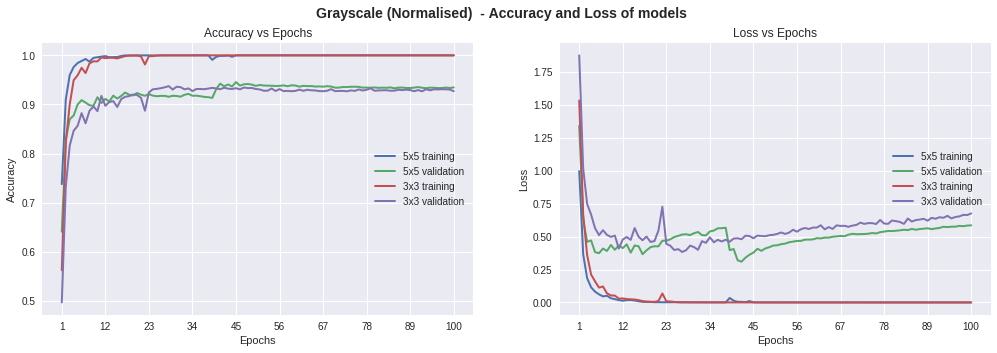

In [0]:
metrics_arr = [g_norm_5x5_tr_metrics, g_norm_5x5_val_metrics, g_norm_3x3_tr_metrics, g_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))     

The 3x3 nodel shows more erratic behaviour, which is hard to explain at this stage. Overall, it performs slighty better. Sadly none of the 2 model reach 93% test accuracy. It is time to set our eyes on dropout.

### Dropout - Keep 75% of weights in Fully Connected Layers

Let's start with a keep percentage of 75% to see what kind of results we get... We will also keep weights in the convolutional layers with a probability of 90%.

#### Color (Normalised)

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_3x3_Color_Dropout_0.75", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [0]:
me_c_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_c_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics, c_norm_drpt_0_75_3x3_duration) = me_c_norm_drpt_0_75_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(_c_norm_drpt_0_75_3x3_ts_accuracy, c_norm_drpt_0_75_3x3_ts_loss, c_norm_drpt_0_75_ts_duration) =  me_c_norm_drpt_0_75_3x3.test_model(X_test_normalised, y_test)

Training EdLeNet_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=5.961s | train: time=3.501s, loss=2.1745, acc=0.4061 | val: time=2.460s, loss=2.3471, acc=0.3603
[10]	total=5.025s | train: time=2.678s, loss=0.0289, acc=0.9948 | val: time=2.347s, loss=0.1826, acc=0.9546
[20]	total=5.029s | train: time=2.689s, loss=0.0039, acc=0.9996 | val: time=2.340s, loss=0.1825, acc=0.9669
[30]	total=5.029s | train: time=2.676s, loss=0.0013, acc=0.9999 | val: time=2.354s, loss=0.2121, acc=0.9655
[40]	total=5.016s | train: time=2.680s, loss=0.0003, acc=1.0000 | val: time=2.336s, loss=0.1611, acc=0.9732
[50]	total=5.031s | train: time=2.678s, loss=0.0004, acc=1.0000 | val: time=2.353s, loss=0.1080, acc=0.9785
[60]	total=5.015s | train: time=2.678s, loss=0.0001, acc=1.0000 | val: time=2.338s, loss=0.0878, acc=0.9834
[70]	total=5.108s | train: time=2.761s, loss=0.0002, acc=1.0000 | val: time=2.347s, loss=0.1867, acc=0.9635
[80]	total=5.020s | train: time=2.685s, loss=0.0000, acc=1.0000 

In [0]:
(c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_5x5_duration) = me_c_norm_drpt_0_75_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_75_5x5_ts_accuracy, c_norm_drpt_0_75_5x5_ts_loss, c_norm_drpt_0_75_5x5_ts_duration) =  me_c_norm_drpt_0_75_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_3x3_Color_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=5.154s | train: time=2.942s, loss=1.9844, acc=0.4988 | val: time=2.212s, loss=2.1516, acc=0.4263
[10]	total=4.526s | train: time=2.403s, loss=0.0299, acc=0.9943 | val: time=2.124s, loss=0.1569, acc=0.9603
[20]	total=4.509s | train: time=2.407s, loss=0.0055, acc=0.9990 | val: time=2.102s, loss=0.1378, acc=0.9639
[30]	total=4.465s | train: time=2.382s, loss=0.0016, acc=0.9998 | val: time=2.083s, loss=0.1199, acc=0.9741
[40]	total=4.531s | train: time=2.411s, loss=0.0008, acc=0.9999 | val: time=2.120s, loss=0.1964, acc=0.9642
[50]	total=4.527s | train: time=2.418s, loss=0.0003, acc=1.0000 | val: time=2.109s, loss=0.1473, acc=0.9703
[60]	total=4.519s | train: time=2.409s, loss=0.0002, acc=1.0000 | val: time=2.109s, loss=0.1297, acc=0.9773
[70]	total=4.527s | train: time=2.411s, loss=0.0002, acc=1.0000 | val: time=2.117s, loss=0.1368, acc=0.9748
[80]	total=4.625s | train: time=2.503s, loss=0.0003, acc=0.9999 

Length of axis: (2,)


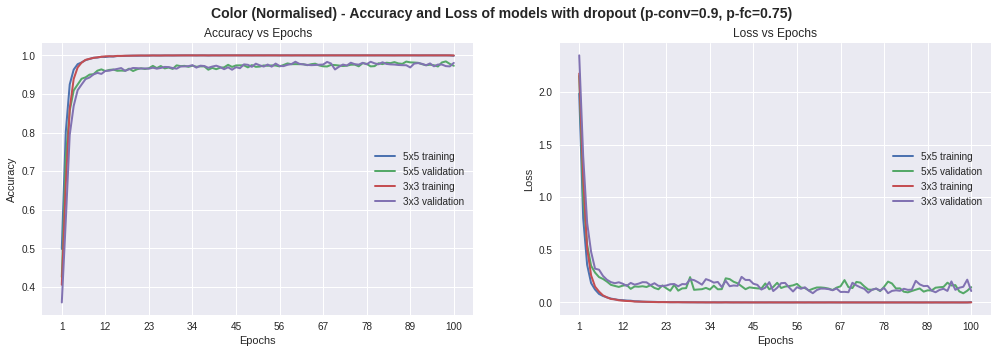

In [0]:
metrics_arr = [c_norm_drpt_0_75_5x5_tr_metrics, c_norm_drpt_0_75_5x5_val_metrics, c_norm_drpt_0_75_3x3_tr_metrics, c_norm_drpt_0_75_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation"]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (Normalised) - Accuracy and Loss of models with dropout (p-conv=0.9, p-fc=0.75)"
                    , fig_size=(17, 5))     

We are seeing some gret results with the introduction of dropout. The 5x5 model achieves above 96% accuracy while **the 3x3 model achieves over 97% test accuracy**. We should get similar, if not better results, with grayscale images.

#### Grayscale (Normalised)

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_3x3_Dropout_0.75", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.9, 0.75])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_Norm_5x5_Dropout_0.75", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.9, 0.75])

In [0]:
me_g_norm_drpt_0_75_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_75_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics, g_norm_drpt_0_75_3x3_duration) = me_g_norm_drpt_0_75_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_3x3_ts_accuracy, g_norm_drpt_0_75_3x3_ts_loss, g_norm_drpt_0_75_ts_3x3_duration) =  me_g_norm_drpt_0_75_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_3x3_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=4.628s | train: time=2.586s, loss=2.7293, acc=0.3099 | val: time=2.042s, loss=2.9083, acc=0.2522
[10]	total=4.285s | train: time=2.316s, loss=0.0362, acc=0.9932 | val: time=1.969s, loss=0.1368, acc=0.9649
[20]	total=4.288s | train: time=2.316s, loss=0.0064, acc=0.9990 | val: time=1.972s, loss=0.0851, acc=0.9812
[30]	total=4.301s | train: time=2.319s, loss=0.0016, acc=0.9998 | val: time=1.982s, loss=0.0844, acc=0.9812
[40]	total=4.263s | train: time=2.307s, loss=0.0006, acc=1.0000 | val: time=1.956s, loss=0.0790, acc=0.9837
[50]	total=4.258s | train: time=2.308s, loss=0.0005, acc=0.9999 | val: time=1.950s, loss=0.0854, acc=0.9814
[60]	total=4.281s | train: time=2.318s, loss=0.0003, acc=1.0000 | val: time=1.963s, loss=0.0780, acc=0.9839
[70]	total=4.287s | train: time=2.313s, loss=0.0001, acc=1.0000 | val: time=1.973s, loss=0.1093, acc=0.9821
[80]	total=4.373s | train: time=2.405s, loss=0.0001, ac

In [0]:
(g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_5x5_duration) = me_g_norm_drpt_0_75_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_75_5x5_ts_accuracy, g_norm_drpt_0_75_5x5_ts_loss, g_norm_drpt_0_75_ts_5x5_duration) =  me_g_norm_drpt_0_75_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Grayscale_Norm_5x5_Dropout_0.75 [epochs=100, batch_size=512]...

[1]	total=3.919s | train: time=2.220s, loss=1.8008, acc=0.5377 | val: time=1.700s, loss=2.0277, acc=0.4803
[10]	total=3.555s | train: time=1.923s, loss=0.0287, acc=0.9949 | val: time=1.632s, loss=0.1649, acc=0.9556
[20]	total=3.655s | train: time=2.024s, loss=0.0061, acc=0.9990 | val: time=1.631s, loss=0.1232, acc=0.9687
[30]	total=3.650s | train: time=2.019s, loss=0.0017, acc=0.9998 | val: time=1.631s, loss=0.1234, acc=0.9739
[40]	total=3.554s | train: time=1.925s, loss=0.0006, acc=0.9999 | val: time=1.629s, loss=0.2063, acc=0.9694
[50]	total=3.562s | train: time=1.931s, loss=0.0009, acc=0.9998 | val: time=1.631s, loss=0.1442, acc=0.9746
[60]	total=3.660s | train: time=2.019s, loss=0.0004, acc=1.0000 | val: time=1.641s, loss=0.0715, acc=0.9868
[70]	total=3.564s | train: time=1.934s, loss=0.0001, acc=1.0000 | val: time=1.631s, loss=0.0846, acc=0.9855
[80]	total=3.560s | train: time=1.923s, loss=0.0001, ac

Length of axis: (2,)


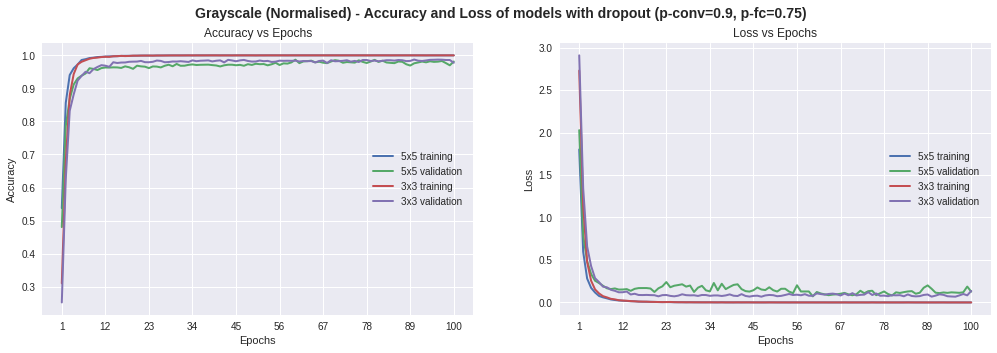

In [0]:
metrics_arr = [g_norm_drpt_0_75_5x5_tr_metrics, g_norm_drpt_0_75_5x5_val_metrics, g_norm_drpt_0_75_3x3_tr_metrics, g_norm_drpt_0_75_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (Normalised) - Accuracy and Loss of models with dropout (p-conv=0.9, p-fc=0.75)"
                    , fig_size=(17, 5))     

Once again, both 3x3 and 5x5 variants are very close, accuracy-wise on all dataset types. Interestingly, the 3x3 model achieves lower loss but also lower accuracy than its counterpart 3x3 model on color images. We should do more runs of those models to determine which one performs better over the long run in the future. But We believe that we don't need to go that far: we can use even more aggressive dropout values to obtain better results.

### Dropout - Keep Fully Connected Weights with a 50% probability

#### Grayscale

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Norm_Grayscale_5x5_Dropout_0.50", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [0]:
me_g_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)
me_g_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics, g_norm_drpt_0_50_3x3_duration) = me_g_norm_drpt_0_50_3x3.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_3x3_ts_accuracy, g_norm_drpt_0_50_3x3_ts_loss, g_norm_drpt_0_50_ts_3x3_duration) =  me_g_norm_drpt_0_50_3x3.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Norm_Grayscale_3x3_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=4.709s | train: time=2.610s, loss=3.5071, acc=0.1157 | val: time=2.099s, loss=3.5562, acc=0.0857
[10]	total=4.408s | train: time=2.416s, loss=0.2625, acc=0.9277 | val: time=1.992s, loss=0.3520, acc=0.8941
[20]	total=4.269s | train: time=2.301s, loss=0.0474, acc=0.9904 | val: time=1.968s, loss=0.1031, acc=0.9689
[30]	total=4.300s | train: time=2.321s, loss=0.0160, acc=0.9970 | val: time=1.979s, loss=0.0757, acc=0.9764
[40]	total=4.283s | train: time=2.314s, loss=0.0089, acc=0.9983 | val: time=1.969s, loss=0.0679, acc=0.9825
[50]	total=4.326s | train: time=2.336s, loss=0.0043, acc=0.9993 | val: time=1.989s, loss=0.0580, acc=0.9844
[60]	total=4.385s | train: time=2.410s, loss=0.0022, acc=0.9996 | val: time=1.975s, loss=0.0488, acc=0.9871
[70]	total=4.266s | train: time=2.301s, loss=0.0012, acc=0.9999 | val: time=1.965s, loss=0.0547, acc=0.9862
[80]	total=4.261s | train: time=2.308s, loss=0.0010, ac

In [0]:
(g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_5x5_duration) = me_g_norm_drpt_0_50_5x5.train_model(X_train_grayscale_normalised, y_train, X_valid_grayscale_normalised, y_valid, epochs=100)
(g_norm_drpt_0_50_5x5_ts_accuracy, g_norm_drpt_0_50_5x5_ts_loss, g_norm_drpt_0_50_ts_5x5_duration) =  me_g_norm_drpt_0_50_5x5.test_model(X_test_grayscale_normalised, y_test)

Training EdLeNet_Norm_Grayscale_5x5_Dropout_0.50 [epochs=100, batch_size=512]...

[1]	total=3.788s | train: time=2.081s, loss=3.3853, acc=0.1829 | val: time=1.706s, loss=3.4396, acc=0.1358
[10]	total=3.570s | train: time=1.928s, loss=0.2216, acc=0.9551 | val: time=1.642s, loss=0.3477, acc=0.9045
[20]	total=3.605s | train: time=1.953s, loss=0.0508, acc=0.9919 | val: time=1.651s, loss=0.1537, acc=0.9531
[30]	total=3.662s | train: time=2.025s, loss=0.0181, acc=0.9965 | val: time=1.637s, loss=0.1221, acc=0.9669
[40]	total=3.564s | train: time=1.926s, loss=0.0091, acc=0.9983 | val: time=1.637s, loss=0.1060, acc=0.9683
[50]	total=3.646s | train: time=1.990s, loss=0.0047, acc=0.9991 | val: time=1.656s, loss=0.0849, acc=0.9726
[60]	total=3.582s | train: time=1.937s, loss=0.0035, acc=0.9993 | val: time=1.645s, loss=0.0980, acc=0.9719
[70]	total=3.640s | train: time=2.009s, loss=0.0021, acc=0.9995 | val: time=1.631s, loss=0.0982, acc=0.9730
[80]	total=3.628s | train: time=2.011s, loss=0.0011, ac

Length of axis: (2,)


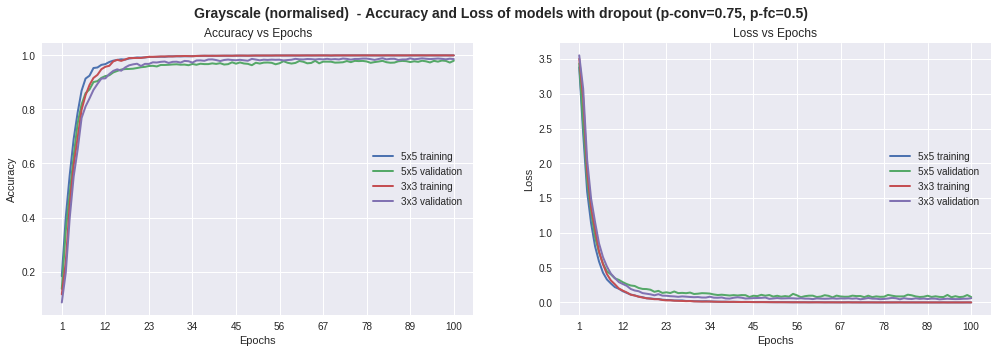

In [0]:
metrics_arr = [g_norm_drpt_0_50_5x5_tr_metrics, g_norm_drpt_0_50_5x5_val_metrics, g_norm_drpt_0_50_3x3_tr_metrics, g_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Both models show smooth, satisfying on the curves. The 3x3 model clearly seems to perform the best. While we are able to score above 98% accuracy on vaidation set, we have not been able to break through this barrier yet on the test set, but we are close!

#### Color

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_3x3_Dropout_0.40", [32, 32, 3], [3, 32, 3], [120, 84], n_classes, [0.75, 0.5])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Color_Norm_5x5_Dropout_0.40", [32, 32, 3], [5, 32, 2], [120, 84], n_classes, [0.75, 0.5])

In [0]:
me_c_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
me_c_norm_drpt_0_50_5x5 = ModelExecutor(mc_5x5, learning_rate=0.001)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics, c_norm_drpt_0_50_3x3_duration) = me_c_norm_drpt_0_50_3x3.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_3x3_ts_accuracy, c_norm_drpt_0_50_3x3_ts_loss, c_norm_drpt_0_50_3x3_ts_duration) =  me_c_norm_drpt_0_50_3x3.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_3x3_Dropout_0.40 [epochs=100, batch_size=512]...

[1]	total=5.302s | train: time=2.839s, loss=3.4365, acc=0.1592 | val: time=2.463s, loss=3.4830, acc=0.1392
[10]	total=5.114s | train: time=2.755s, loss=0.4914, acc=0.8520 | val: time=2.359s, loss=0.6455, acc=0.8200
[20]	total=4.983s | train: time=2.651s, loss=0.0657, acc=0.9872 | val: time=2.332s, loss=0.1800, acc=0.9590
[50]	total=5.057s | train: time=2.674s, loss=0.0033, acc=0.9995 | val: time=2.383s, loss=0.0814, acc=0.9819
[60]	total=5.031s | train: time=2.657s, loss=0.0021, acc=0.9996 | val: time=2.374s, loss=0.0780, acc=0.9823
[70]	total=4.983s | train: time=2.658s, loss=0.0014, acc=0.9998 | val: time=2.324s, loss=0.0728, acc=0.9846
[80]	total=5.002s | train: time=2.660s, loss=0.0013, acc=0.9998 | val: time=2.342s, loss=0.0898, acc=0.9816
[90]	total=5.037s | train: time=2.666s, loss=0.0006, acc=0.9999 | val: time=2.371s, loss=0.0878, acc=0.9832
[100]	total=5.055s | train: time=2.679s, loss=0.0006, acc=0

In [0]:
(c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_5x5_duration) = me_c_norm_drpt_0_50_5x5.train_model(X_train_normalised, y_train, X_valid_normalised, y_valid, epochs=100)
(c_norm_drpt_0_50_5x5_ts_accuracy, c_norm_drpt_0_50_5x5_ts_loss, c_norm_drpt_0_50_5x5_ts_duration) =  me_c_norm_drpt_0_50_5x5.test_model(X_test_normalised, y_test)

Training EdLeNet_Color_Norm_5x5_Dropout_0.40 [epochs=100, batch_size=512]...

[1]	total=4.776s | train: time=2.545s, loss=3.3445, acc=0.2146 | val: time=2.231s, loss=3.4083, acc=0.1898
[10]	total=4.576s | train: time=2.412s, loss=0.2542, acc=0.9435 | val: time=2.164s, loss=0.3687, acc=0.8939
[20]	total=4.492s | train: time=2.378s, loss=0.0577, acc=0.9914 | val: time=2.114s, loss=0.1499, acc=0.9660
[30]	total=4.670s | train: time=2.515s, loss=0.0180, acc=0.9970 | val: time=2.155s, loss=0.1117, acc=0.9737
[40]	total=4.511s | train: time=2.389s, loss=0.0076, acc=0.9985 | val: time=2.122s, loss=0.0637, acc=0.9825
[50]	total=4.574s | train: time=2.487s, loss=0.0036, acc=0.9995 | val: time=2.087s, loss=0.0715, acc=0.9800
[60]	total=4.494s | train: time=2.398s, loss=0.0042, acc=0.9991 | val: time=2.096s, loss=0.0676, acc=0.9805
[70]	total=4.596s | train: time=2.487s, loss=0.0022, acc=0.9994 | val: time=2.109s, loss=0.0977, acc=0.9776
[80]	total=4.513s | train: time=2.406s, loss=0.0013, acc=0.

Length of axis: (2,)


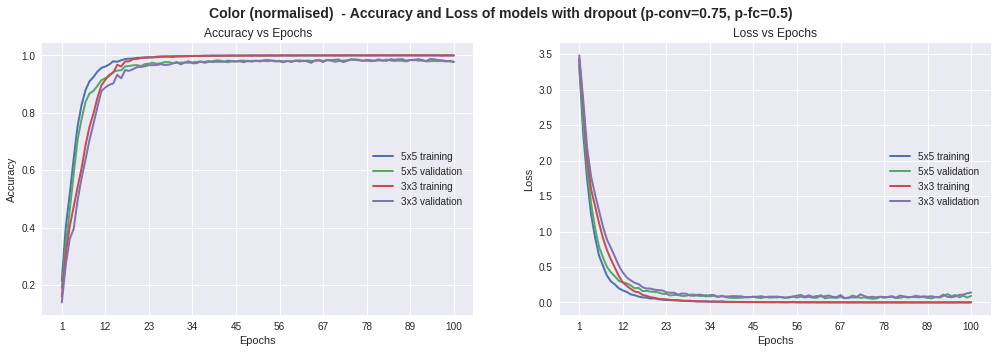

In [0]:
metrics_arr = [c_norm_drpt_0_50_5x5_tr_metrics, c_norm_drpt_0_50_5x5_val_metrics, c_norm_drpt_0_50_3x3_tr_metrics, c_norm_drpt_0_50_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Color (normalised)  - Accuracy and Loss of models with dropout (p-conv=0.75, p-fc=0.5)"
                    , fig_size=(17, 5))

Color and grayscale images exhibit very similar behaviour, with maybe the advantage for grayscale, lower losses on test accuracy. At this stage we are unable to pick between grayscale or color for the input images since we obtain very similar results in both cases. Maybe color is not much of an issue in fact if the model performs so well on grayscale images? 
We will next turn to augmenting images and explore whether we can reach better results by randomly applying distortions to our images.

## Histogram Equalization

We observed earlier that some of the images in the dataset were quite dark, and others blurry. We are aiming at taclking this problem in this part where we attempt to apply [histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) techniques to improve the contrast of our images and therefore make it easier for our model to discern which class the supplied image ultimately belongs to with a higher level of confidence.
To do so, we are going to rely on OpenCV's [CLAHE](http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) (Contrast Limiting Adaptive Histogram Equalization) function.

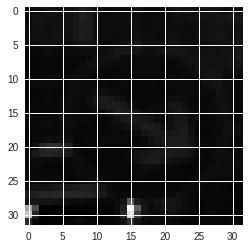

In [0]:
g_img = np.reshape(X_train_grayscale[15796], (32, 32))
plt.imshow(g_img, cmap='gray')

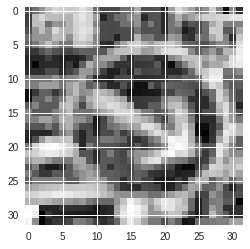

In [0]:
clahe = cv2.createCLAHE(tileGridSize=(4,4), clipLimit=40.0)
cl1 = clahe.apply(g_img)
plt.imshow(cl1, cmap='gray')

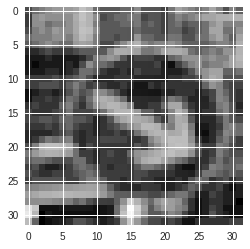

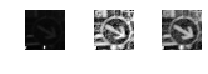

In [0]:
clahe = cv2.createCLAHE(tileGridSize=(2,2), clipLimit=15.0)
cl2 = clahe.apply(g_img)
plt.imshow(cl2, cmap='gray')
show_image_list([g_img, cl1, cl2], ["L0","L1", "l2"], "", cols=3, fig_size=(3, 3), show_ticks=False)

We choose CLAHE with grid size of 2x2 and climit limit of 15.

In [0]:
X_train_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_grayscale)))
X_valid_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_valid_grayscale)))
X_test_grayscale_equalized = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_test_grayscale)))

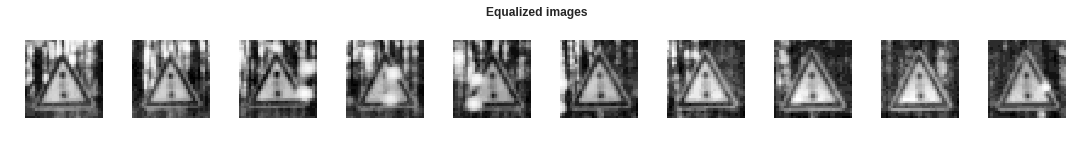

In [0]:
show_image_list(X_train_grayscale_equalized[1640:1650], y_train[1640:1650], "Equalized images", fig_size=(15, 10), cols=10, show_ticks=False)

### Model evaluation 

In [0]:
# Let's normalise our images beforehand
X_train_grayscale_equalized_normalised = normalise_images(X_train_grayscale_equalized, X_train_grayscale_equalized)
X_valid_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_grayscale_equalized)
X_test_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_grayscale_equalized)


In [0]:
# Let's not forget to reshape our images
X_train_grayscale_equalized = np.reshape(X_train_grayscale_equalized, (X_train_grayscale_equalized.shape[0], 32, 32, 1))
X_valid_grayscale_equalized = np.reshape(X_valid_grayscale_equalized, (X_valid_grayscale_equalized.shape[0], 32, 32, 1))
X_test_grayscale_equalized = np.reshape(X_test_grayscale_equalized, (X_test_grayscale_equalized.shape[0], 32, 32, 1))

X_train_grayscale_equalized_normalised = np.reshape(X_train_grayscale_equalized_normalised, (X_train_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_grayscale_equalized_normalised = np.reshape(X_valid_grayscale_equalized_normalised, (X_valid_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_grayscale_equalized_normalised = np.reshape(X_test_grayscale_equalized_normalised, (X_test_grayscale_equalized_normalised.shape[0], 32, 32, 1))

#### Normalised images With No Dropout

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])
mc_5x5 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_5x5", [32, 32, 1], [5, 32, 2], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_g_clahe_norm_3x3 = ModelExecutor(mc_3x3)
me_g_clahe_norm_5x5 = ModelExecutor(mc_5x5)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet] Building neural network [conv layers=2, conv filter size=5, conv start depth=32, fc layers=2]


In [0]:
(g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics, g_clahe_norm_3x3_duration) = me_g_clahe_norm_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_3x3_ts_accuracy, g_clahe_norm_3x3_ts_loss, g_clahe_norm_3x3_ts_duration) =  me_g_clahe_norm_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_3x3 [epochs=100, batch_size=512]...

[1]	total=4.685s | train: time=2.634s, loss=1.1140, acc=0.6703 | val: time=2.051s, loss=1.3121, acc=0.6100
[10]	total=4.294s | train: time=2.324s, loss=0.0321, acc=0.9917 | val: time=1.969s, loss=0.2833, acc=0.9320
[20]	total=4.299s | train: time=2.322s, loss=0.0014, acc=1.0000 | val: time=1.977s, loss=0.2177, acc=0.9510
[30]	total=4.292s | train: time=2.317s, loss=0.0005, acc=1.0000 | val: time=1.975s, loss=0.2430, acc=0.9508
[40]	total=4.298s | train: time=2.315s, loss=0.0002, acc=1.0000 | val: time=1.982s, loss=0.2560, acc=0.9506
[50]	total=4.302s | train: time=2.321s, loss=0.0001, acc=1.0000 | val: time=1.981s, loss=0.2693, acc=0.9519
[60]	total=4.279s | train: time=2.315s, loss=0.0001, acc=1.0000 | val: time=1.964s, loss=0.2783, acc=0.9517
[70]	total=4.299s | train: time=2.320s, loss=0.0000, acc=1.0000 | val: time=1.979s, loss=0.2923, acc=0.9524
[80]	total=4.297s | train: time=2.323s, loss=0.0000, acc=1.000

In [0]:
(g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_5x5_duration) = me_g_clahe_norm_5x5.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=100)
(g_clahe_norm_5x5_ts_accuracy, g_clahe_norm_5x5_ts_loss, g_clahe_norm_5x5_ts_duration) =  me_g_clahe_norm_5x5.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_5x5 [epochs=100, batch_size=512]...

[1]	total=3.968s | train: time=2.245s, loss=0.5837, acc=0.8331 | val: time=1.723s, loss=0.8099, acc=0.7714
[10]	total=3.653s | train: time=2.015s, loss=0.0103, acc=0.9989 | val: time=1.637s, loss=0.2670, acc=0.9324
[20]	total=3.571s | train: time=1.931s, loss=0.0007, acc=1.0000 | val: time=1.640s, loss=0.2516, acc=0.9433
[30]	total=3.676s | train: time=2.025s, loss=0.0003, acc=1.0000 | val: time=1.651s, loss=0.2733, acc=0.9429
[40]	total=3.649s | train: time=2.013s, loss=0.0001, acc=1.0000 | val: time=1.635s, loss=0.2863, acc=0.9469
[50]	total=3.672s | train: time=2.018s, loss=0.0001, acc=1.0000 | val: time=1.654s, loss=0.3059, acc=0.9444
[60]	total=3.736s | train: time=2.027s, loss=0.0000, acc=1.0000 | val: time=1.709s, loss=0.3174, acc=0.9463
[70]	total=3.562s | train: time=1.928s, loss=0.0000, acc=1.0000 | val: time=1.634s, loss=0.3236, acc=0.9469
[80]	total=3.567s | train: time=1.931s, loss=0.0000, acc=1.000

Length of axis: (2,)


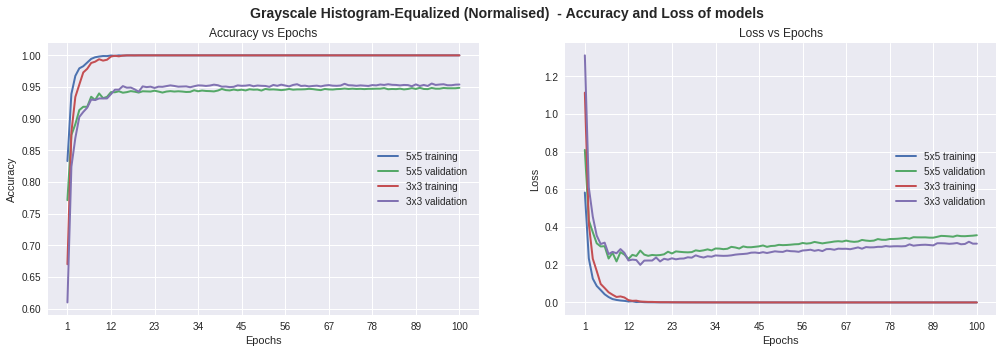

In [0]:
metrics_arr = [g_clahe_norm_5x5_tr_metrics, g_clahe_norm_5x5_val_metrics, g_clahe_norm_3x3_tr_metrics, g_clahe_norm_3x3_val_metrics]
lbs = ["5x5 training", "5x5 validation", "3x3 training", "3x3 validation "]
plot_model_results(metrics_arr, [2, 1], lbs, ["Epochs", "Epochs"], ["Accuracy", "Loss"], 
                   ["Accuracy vs Epochs", 
                    "Loss vs Epochs"],
                   "Grayscale Histogram-Equalized (Normalised)  - Accuracy and Loss of models"
                    , fig_size=(17, 5))

The 3x3 model performs better, topping 93% test accuracy, but we can see on the graph of _Loss vs Epochs_ that our models losses increase as the epochs go by, which would indicate that we are overfitting and no working hard enough to extract features that generalise. 
We will try applying aggressive dropout values, with the hope that this helps alleviate the loss and improve the accuracy.

#### Normalised images With Dropout

We apply our best model with two levels of dropout (p-conv=0.75, p-fc=0.5) on non-normalised histogram-equalised images.

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.5, 0.5])


In [0]:
me_g_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [0]:
(g_clahe_norm_drpt_0_50_3x3_tr_metrics, g_clahe_norm_drpt_0_50_3x3_val_metrics, g_clahe_norm_drpt_0_50_3x3_duration) = me_g_clahe_norm_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)
(g_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_drpt_0_50_3x3_ts_loss, g_clahe_norm_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 [epochs=500, batch_size=512]...

[1]	total=4.703s | train: time=2.646s, loss=3.6658, acc=0.0581 | val: time=2.057s, loss=3.6793, acc=0.0524
[10]	total=4.309s | train: time=2.328s, loss=1.4535, acc=0.5337 | val: time=1.981s, loss=1.5353, acc=0.5032
[20]	total=4.389s | train: time=2.411s, loss=0.6319, acc=0.8017 | val: time=1.978s, loss=0.6697, acc=0.7964
[30]	total=4.231s | train: time=2.301s, loss=0.3067, acc=0.9058 | val: time=1.929s, loss=0.3358, acc=0.8875
[40]	total=4.231s | train: time=2.289s, loss=0.1882, acc=0.9279 | val: time=1.942s, loss=0.2239, acc=0.9118
[50]	total=4.244s | train: time=2.303s, loss=0.1211, acc=0.9776 | val: time=1.941s, loss=0.1444, acc=0.9714
[60]	total=4.241s | train: time=2.296s, loss=0.0660, acc=0.9880 | val: time=1.946s, loss=0.0899, acc=0.9794
[70]	total=4.233s | train: time=2.293s, loss=0.0450, acc=0.9916 | val: time=1.940s, loss=0.0824, acc=0.9766
[80]	total=4.230s | train: time=2.294s, loss=0.03

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])

In [0]:
me_g_clahe_norm_take2_drpt_0_50_3x3 = ModelExecutor(mc_3x3)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [0]:
(g_clahe_norm_take2_drpt_0_50_3x3_tr_metrics, g_clahe_norm_take2_drpt_0_50_3x3_val_metrics, g_clahe_norm_take2_drpt_0_50_3x3_duration)    =  me_g_clahe_norm_take2_drpt_0_50_3x3.train_model(X_train_grayscale_equalized_normalised, y_train, X_valid_grayscale_equalized_normalised, y_valid, epochs=500)
(g_clahe_norm_take2_drpt_0_50_3x3_ts_accuracy, g_clahe_norm_take2_drpt_0_50_3x3_ts_loss,    g_clahe_norm_take2_drpt_0_50_ts_3x3_duration) =  me_g_clahe_norm_take2_drpt_0_50_3x3.test_model(X_test_grayscale_equalized_normalised, y_test)

Training EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50 [epochs=500, batch_size=512]...

[1]	total=4.658s | train: time=2.621s, loss=3.6229, acc=0.0796 | val: time=2.036s, loss=3.6440, acc=0.0769
[10]	total=4.295s | train: time=2.328s, loss=0.8202, acc=0.7479 | val: time=1.968s, loss=0.8903, acc=0.7068
[20]	total=4.236s | train: time=2.298s, loss=0.2797, acc=0.9047 | val: time=1.938s, loss=0.3108, acc=0.8950
[30]	total=4.239s | train: time=2.302s, loss=0.1325, acc=0.9669 | val: time=1.937s, loss=0.1630, acc=0.9549
[40]	total=4.241s | train: time=2.299s, loss=0.0509, acc=0.9897 | val: time=1.942s, loss=0.0914, acc=0.9728
[50]	total=4.331s | train: time=2.389s, loss=0.0263, acc=0.9951 | val: time=1.942s, loss=0.0648, acc=0.9798
[60]	total=4.233s | train: time=2.303s, loss=0.0148, acc=0.9972 | val: time=1.930s, loss=0.0486, acc=0.9857
[70]	total=4.235s | train: time=2.300s, loss=0.0112, acc=0.9977 | val: time=1.935s, loss=0.0399, acc=0.9891
[80]	total=4.249s | train: time=2.302s, lo

**The 3x3 CLAHE - Take 2- achieves a remarkable 97.75% accuracy with loss score under 0.1. That is so far our best model.**

#### Analysis of 3x3 Model performance

In [0]:
test_preds = me_g_norm_drpt_0_75_3x3.predict(X_test_grayscale_equalized_normalised)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_Norm_3x3_Dropout_0.75.chkpt


In [0]:
test_preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(X_test_grayscale_equalized_normalised)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [0]:
good_test_preds = test_preds == y_test
bad_test_preds = test_preds != y_test

In [0]:
bad_test_pred_imgs = X_test_grayscale_equalized[bad_test_preds]
good_test_pred_imgs = X_test_grayscale_equalized[good_test_preds]
bad_test_pred_correct_lb = y_test[bad_test_preds]
bad_test_pred_incorrect_lb = test_preds[bad_test_preds]

In [0]:
print("Number of good predictions: {0}/{1}".format(len(good_test_pred_imgs), len(y_test)))
print("Number of bad predictions: {0}/{1}".format(len(bad_test_pred_imgs), len(y_test)))

Number of good predictions: 12355/12630
Number of bad predictions: 275/12630


We have 284 images where our prediction was incorrect. Let's visualize some of them to better understand what's going on.

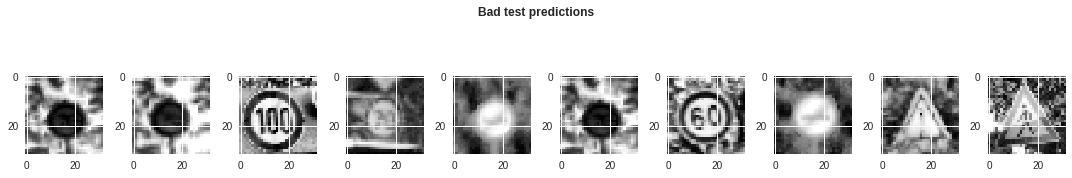

In [0]:
count = 10
idx = np.random.randint(0, high=len(bad_test_pred_imgs), size=10)
show_image_list(bad_test_pred_imgs[idx], bad_test_pred_incorrect_lb[idx], "Bad test predictions", cols=count)

Some of the images are very blurry, despite our histogram equalization, while others seem distored. We turn to data augmentation to address these issues.

## Data Augmentation

We observed earlier that the data presented glaring imbalance across the 43 classes. Yet it does not seem to be a crippling problem as we are able to reach very high accuracy despite the class imbalance. We also noticed that some images in the test set are distorted. We are therefore going to use data augmentation techniques in an attempt to:
1. Minimize imbalances across classes
2. Extend dataset and provide additional pictures in different lighting settings and orientations
3. Improve model's ability to become more generic
4. Improve test and validation accuracy, especially on distorted images

In [0]:
X_train_augs = X_train
y_train_augs = y_train

In [0]:
# This loop augments images per label group
for (lid, lbl), group in X_train_group_by_label:
    #print("[{0}] : {1}".format(lid, lbl))   
    group_count = group['img_id'].size
    idx = group['img_id'].values
    imgs = X_train[idx]

    
    
    # Take a different population of the subset depending on how many images we have already
    # and vary the number of augmentations depending on size of label group
    pt_spacing = 1.0
    p = 1.0
    
    n = group_count * 0.1
    
    
    if group_count > 500 and group_count < 1000:
        pt_spacing = 3.0
    elif group_count >= 1000 and group_count < 2000:
        pt_spacing = 10.0
    elif group_count >= 2000:
        pt_spacing = 20.0
    
    n = int(n)
    
    space_interval = int(group_count / pt_spacing)
    
    rand_idx = np.linspace(0, group_count, num=space_interval, endpoint=False, dtype='int')
    
    selected_rows = group.iloc[rand_idx]
    selected_img = np.array(list(map(lambda img_id: X_train[img_id], selected_rows['img_id'])))
    
    augs = augment_imgs_until_n(selected_img, n, p)
    X_train_augs = np.concatenate((X_train_augs, augs))
    y_train_augs = np.concatenate((y_train_augs, np.repeat(lid, n)))
    
print("New Augmented arrays shape: {0} and {1}".format(X_train_augs.shape, y_train_augs.shape))

New Augmented arrays shape: (38278, 32, 32, 3) and (38278,)


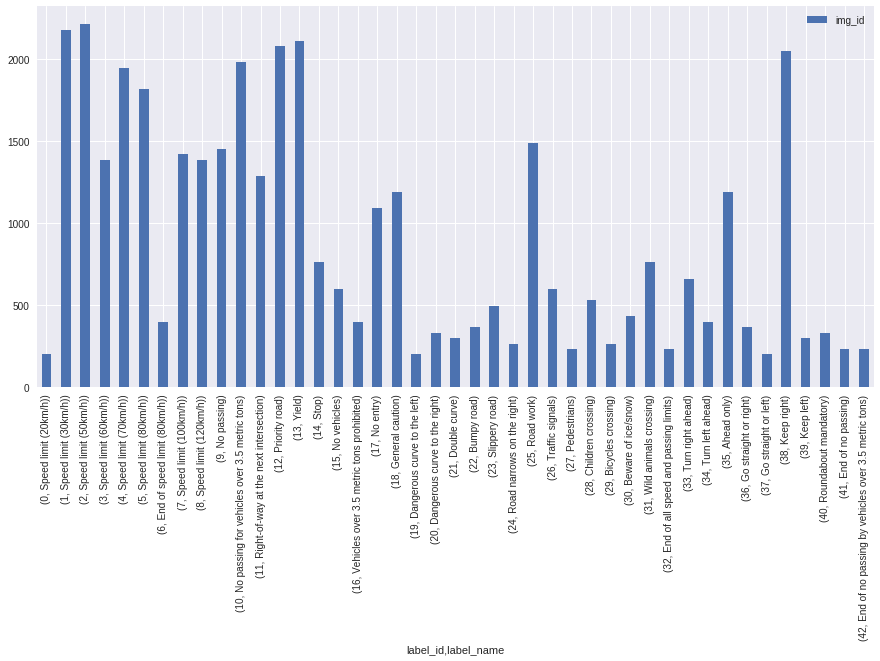

In [0]:
X_train_augs_id_to_label = group_img_id_to_lbl(y_train_augs, sign_names)
X_train_augs_group_by_label_count = group_img_id_to_lb_count(X_train_augs_id_to_label)

# Now count the number of images for each class and plot the results so that we understand the distribution
X_train_augs_group_by_label_count.plot(kind='bar', figsize=(15, 7))

We have managed to mitigate the gaping imbalance we originally observed, but it is still painfully obvious. We decided to temper our augmentation ambitions as we did not want the model to overwhelmingly learn about augmented images, to the detriment of _real_ images. That's a hard balance to strike in all fairness but we believe we have some interesting results. Now every class has at least 10% of its dataset augmented. Our assumption is that our network should now perform better. Let's put it to the test. The below shows visuals of the new dataset, with some images having been augmented by the steps above.

In [0]:
# Let's plot images from each of these classes
X_train_augs_group_by_label = X_train_augs_id_to_label.groupby(["label_id", "label_name"])

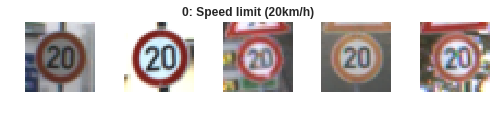

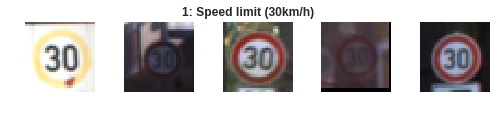

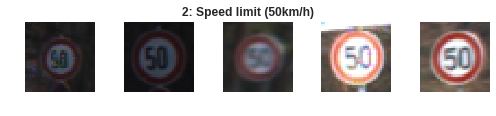

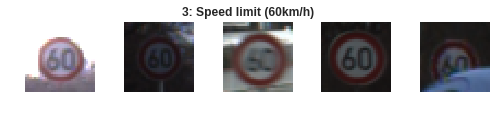

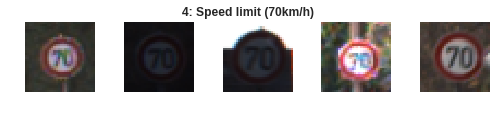

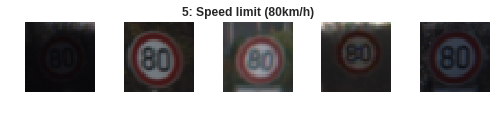

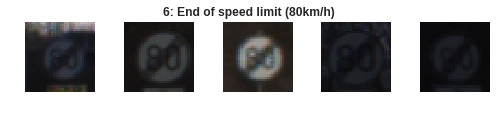

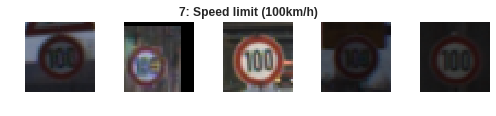

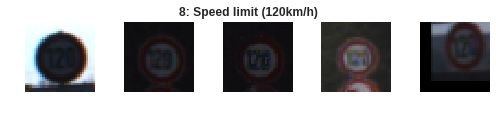

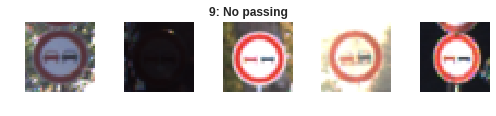

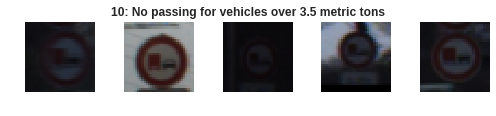

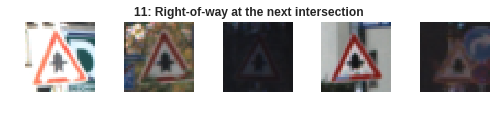

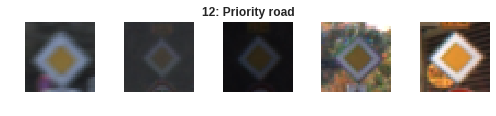

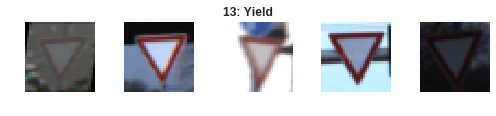

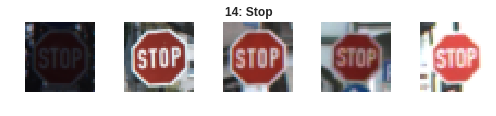

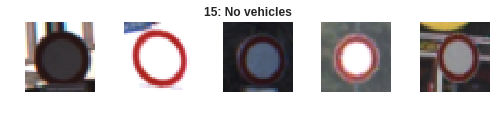

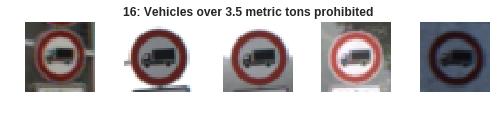

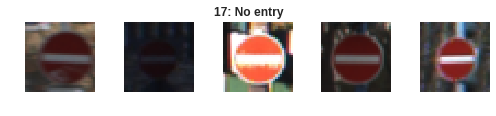

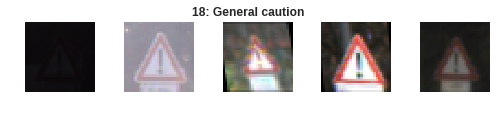

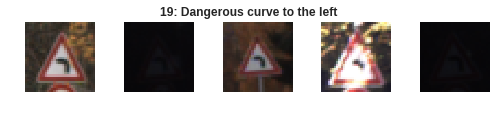

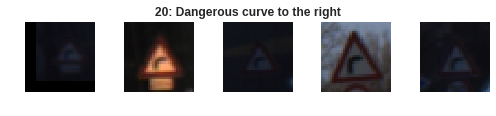

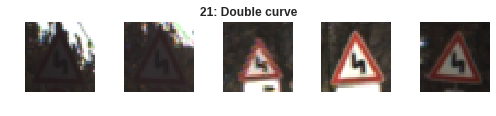

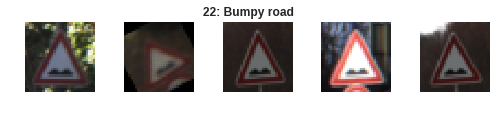

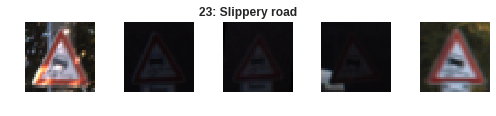

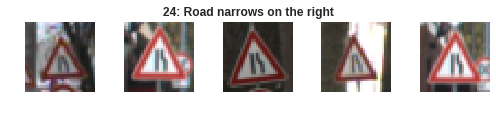

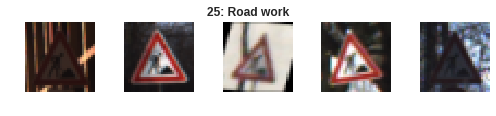

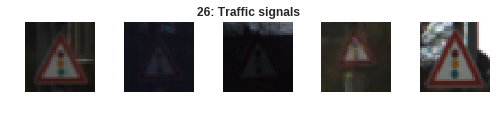

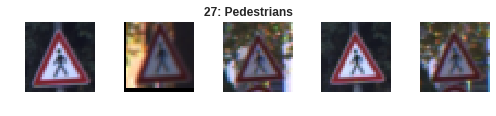

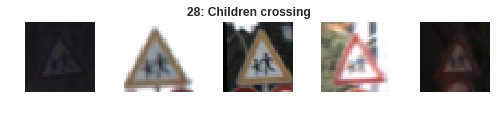

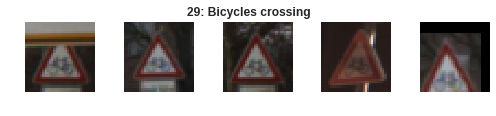

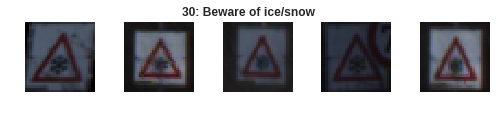

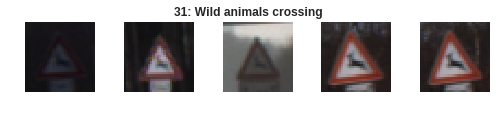

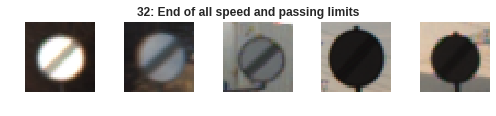

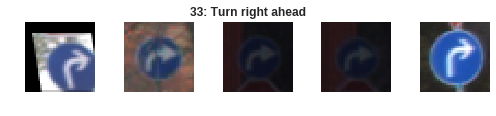

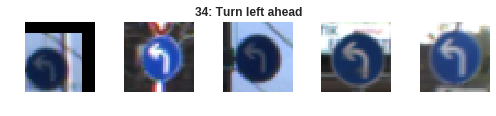

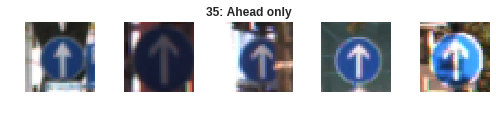

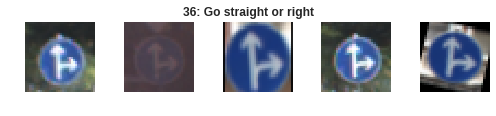

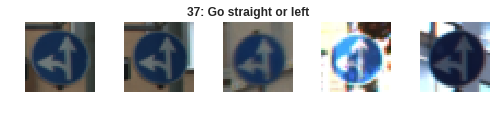

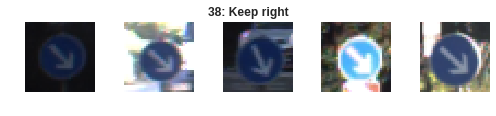

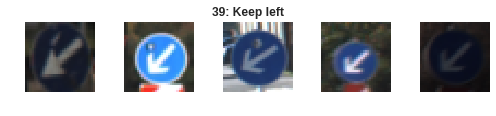

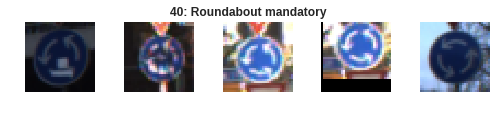

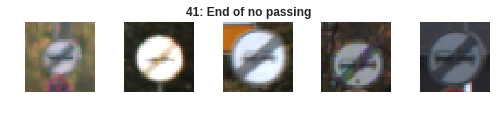

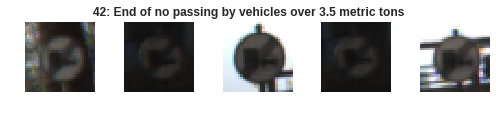

In [0]:
show_random_dataset_images(X_train_augs_group_by_label, X_train_augs)

## Evaluating model on augmented dataset

For this part, we will focus exclusively on grayscale images as they seem to produce better performance. Color images may exhibit close performance but as we plan to also apply histogram equalization the images must be in grayscale.

#### Grayscale Augmented Dataset

In [0]:
# First convert to grayscale
X_train_augs_grayscale = np.asarray(list(map(lambda img: to_grayscale(img), X_train_augs))) 

In [0]:
# Then histogram equalize the grayscale images
X_train_augs_grayscale_equalized  = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), X_train_augs_grayscale )))

In [0]:
# Now normalise using the mean and std of the training set
X_train_augs_grayscale_equalized_normalised = normalise_images(X_train_augs_grayscale_equalized, X_train_augs_grayscale_equalized)
X_valid_augs_grayscale_equalized_normalised = normalise_images(X_valid_grayscale_equalized, X_train_augs_grayscale_equalized)
X_test_augs_grayscale_equalized_normalised = normalise_images(X_test_grayscale_equalized, X_train_augs_grayscale_equalized)


In [0]:
# Reshaping our inputs to a format that tensorflow accepts (i.e. a 4D tensor)
X_train_augs_grayscale_equalized_normalised = np.reshape(X_train_augs_grayscale_equalized_normalised, (X_train_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_valid_augs_grayscale_equalized_normalised = np.reshape(X_valid_augs_grayscale_equalized_normalised, (X_valid_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))
X_test_augs_grayscale_equalized_normalised = np.reshape(X_test_augs_grayscale_equalized_normalised,   (X_test_augs_grayscale_equalized_normalised.shape[0], 32, 32, 1))

#### No Dropout

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [1.0, 1.0])

In [0]:
me_g_augs_clahe_norm_3x3 = ModelExecutor(mc_3x3)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [0]:
(g_augs_clahe_norm_3x3_tr_metrics,  g_augs_clahe_norm_3x3_val_metrics, g_augs_clahe_norm_3x3_duration) = me_g_augs_clahe_norm_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=50, batch_size=4096)


Training EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3 [epochs=50, batch_size=4096]...

[1]	total=6.072s | train: time=4.194s, loss=3.3153, acc=0.1769 | val: time=1.877s, loss=3.4124, acc=0.1503
[10]	total=4.157s | train: time=2.352s, loss=0.4915, acc=0.8688 | val: time=1.805s, loss=0.5864, acc=0.8331
[20]	total=4.201s | train: time=2.374s, loss=0.2179, acc=0.9488 | val: time=1.826s, loss=0.3379, acc=0.9002
[30]	total=4.081s | train: time=2.264s, loss=0.1311, acc=0.9694 | val: time=1.816s, loss=0.2944, acc=0.9075
[40]	total=4.161s | train: time=2.356s, loss=0.0803, acc=0.9821 | val: time=1.806s, loss=0.2818, acc=0.9166
[50]	total=4.157s | train: time=2.354s, loss=0.0489, acc=0.9898 | val: time=1.802s, loss=0.2739, acc=0.9220
Model ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3.chkpt saved


In [0]:
(g_augs_clahe_norm_3x3_ts_accuracy, g_augs_clahe_norm_3x3_ts_loss,     g_augs_clahe_norm_3x3_ts_duration) =  me_g_augs_clahe_norm_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3.chkpt
[EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3 - Test Set]	time=0.836s, loss=0.3315, acc=0.9127


We only ran 50 epochs this time and the results look very encouraging. Let's now try more aggressive values for dropout to see how the model adapts.

#### Dropout - Keep Fully Connected Layer Weights with p=0.5

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.7, 0.5])

In [0]:
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)

[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]


In [0]:
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

Training EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 [epochs=900, batch_size=512]...

[1]	total=5.826s | train: time=3.596s, loss=3.5567, acc=0.0753 | val: time=2.229s, loss=3.5814, acc=0.0825
[10]	total=5.628s | train: time=3.418s, loss=0.7321, acc=0.7942 | val: time=2.210s, loss=0.5540, acc=0.8252
[20]	total=5.637s | train: time=3.420s, loss=0.3561, acc=0.9040 | val: time=2.217s, loss=0.1643, acc=0.9574
[30]	total=5.635s | train: time=3.420s, loss=0.2514, acc=0.9310 | val: time=2.215s, loss=0.0870, acc=0.9776
[40]	total=5.633s | train: time=3.416s, loss=0.2075, acc=0.9423 | val: time=2.217s, loss=0.0686, acc=0.9798
[50]	total=5.635s | train: time=3.417s, loss=0.1804, acc=0.9507 | val: time=2.218s, loss=0.0508, acc=0.9837
[60]	total=5.629s | train: time=3.414s, loss=0.1628, acc=0.9549 | val: time=2.215s, loss=0.0543, acc=0.9812
[70]	total=5.633s | train: time=3.415s, loss=0.1487, acc=0.9575 | val: time=2.218s, loss=0.0474, acc=0.9844
[80]	total=5.635s | train: time=3.416s, loss

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.7, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_train_augs_grayscale_equalized_normalised, y_train_augs)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 - Test Set]	time=2.130s, loss=0.0191, acc=0.9964


In [0]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

[EdLeNet_Augs_Grayscale_CLAHE_Norm_3x3_Dropout_0.50 - Test Set]	time=0.833s, loss=0.1271, acc=0.9687


In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


In [0]:
# TESTING
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take2_3x3_Dropout_0.50 - Test Set]	time=0.786s, loss=0.0982, acc=0.9772


In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.4])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


In [0]:
# TESTING
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [.75, 0.4])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take3_3x3_Dropout_0.50 - Test Set]	time=0.755s, loss=0.1084, acc=0.9767


In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=900, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[880]	total=5.627s | train: time=3.412s, loss=0.0712, acc=0.9813 | val: time=2.215s, loss=0.0334, acc=0.9887


In [0]:
# Verifying test set accuracy
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)



[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50 - Test Set]	time=0.786s, loss=0.0775, acc=0.9782


In [0]:
# Verifying training and validation set
# Training set
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_train_augs_grayscale_equalized_normalised, y_train_augs)
# Validation set
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_valid_augs_grayscale_equalized_normalised, y_valid)

[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50 - Test Set]	time=2.102s, loss=0.0725, acc=0.9815
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50 - Test Set]	time=0.249s, loss=0.0326, acc=0.9893


The model *EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_3x3_Dropout_0.50* gives us our best results to date, with a test accuracy of **97.82%**. Because the loss on the training and validation sets is still relatively high, it indicates that we most likely still have room for manoeuvre, and should therefore run the model for more epochs. Therefore, we will have the current results and re-run the model for twice as many epochs and then observe results. 

In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_Bis_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.6, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=2000, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_Bis_3x3_Dropout_0.50 [epochs=2000, batch_size=512]...

[1]	total=5.824s | train: time=3.594s, loss=3.6283, acc=0.0797 | val: time=2.231s, loss=3.6463, acc=0.0687
[10]	total=5.637s | train: time=3.417s, loss=1.3313, acc=0.5605 | val: time=2.219s, loss=1.1922, acc=0.5746
[20]	total=5.633s | train: time=3.415s, loss=0.6163, acc=0.8038 | val: time=2.217s, loss=0.4257, acc=0.8415
[30]	total=5.628s | train: time=3.414s, loss=0.4165, acc=0.8750 | val: time=2.214s, loss=0.2376, acc=0.9166
[40]	total=5.635s | train: time=3.416s, loss=0.3056, acc=0.9193 | val: time=2.218s, loss=0.1287, acc=0.9639
[50]	total=5.635s | train: time=3.420s, loss=0.2490, acc=0.9330 | val: time=2.215s, loss=0.0835, acc=0.9762
[60]	total=5.637s | train: time=3.415s, loss=0.2236, acc=0.9390 | val: time=2.221s, loss=0.0724, acc=0.9773
[70]	total=5.634s | train: time=3.421

[1200]	total=5.624s | train: time=3.409s, loss=0.0637, acc=0.9833 | val: time=2.215s, loss=0.0328, acc=0.9893
[1210]	total=5.627s | train: time=3.414s, loss=0.0631, acc=0.9833 | val: time=2.213s, loss=0.0328, acc=0.9889
[1220]	total=5.623s | train: time=3.409s, loss=0.0640, acc=0.9838 | val: time=2.214s, loss=0.0296, acc=0.9914
[1230]	total=5.620s | train: time=3.406s, loss=0.0657, acc=0.9827 | val: time=2.214s, loss=0.0321, acc=0.9884
[1240]	total=5.625s | train: time=3.411s, loss=0.0640, acc=0.9834 | val: time=2.213s, loss=0.0303, acc=0.9905
[1250]	total=5.623s | train: time=3.408s, loss=0.0639, acc=0.9833 | val: time=2.214s, loss=0.0332, acc=0.9889
[1260]	total=5.630s | train: time=3.411s, loss=0.0617, acc=0.9842 | val: time=2.219s, loss=0.0308, acc=0.9893
[1270]	total=5.624s | train: time=3.409s, loss=0.0618, acc=0.9840 | val: time=2.215s, loss=0.0297, acc=0.9896
[1280]	total=5.632s | train: time=3.414s, loss=0.0637, acc=0.9842 | val: time=2.218s, loss=0.0343, acc=0.9896
[1290]	tot

[1950]	total=5.625s | train: time=3.409s, loss=0.0536, acc=0.9863 | val: time=2.216s, loss=0.0283, acc=0.9918
[1960]	total=5.626s | train: time=3.410s, loss=0.0537, acc=0.9862 | val: time=2.217s, loss=0.0343, acc=0.9896
[1970]	total=5.627s | train: time=3.408s, loss=0.0525, acc=0.9870 | val: time=2.219s, loss=0.0315, acc=0.9914
[1980]	total=5.627s | train: time=3.409s, loss=0.0530, acc=0.9862 | val: time=2.218s, loss=0.0309, acc=0.9902
[1990]	total=5.628s | train: time=3.412s, loss=0.0521, acc=0.9869 | val: time=2.216s, loss=0.0302, acc=0.9900
[2000]	total=5.632s | train: time=3.415s, loss=0.0521, acc=0.9869 | val: time=2.217s, loss=0.0311, acc=0.9902
Model ./models/EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_Bis_3x3_Dropout_0.50.chkpt saved
[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take4_Bis_3x3_Dropout_0.50 - Test Set]	time=0.678s, loss=0.0842, acc=0.9786


In [0]:
mc_3x3 = ModelConfig(EdLeNet, "EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50", [32, 32, 1], [3, 32, 3], [120, 84], n_classes, [0.65, 0.5])
me_g_augs_clahe_norm_drpt_0_50_3x3 = ModelExecutor(mc_3x3, learning_rate=0.001)
(g_augs_clahe_norm_drpt_0_50_3x3_tr_metrics,  g_augs_clahe_norm_drpt_0_50_3x3_val_metrics, g_augs_clahe_norm_drpt_0_50_3x3_duration) = me_g_augs_clahe_norm_drpt_0_50_3x3.train_model(X_train_augs_grayscale_equalized_normalised, y_train_augs, X_valid_augs_grayscale_equalized_normalised, y_valid, epochs=2000, batch_size=512)
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)


[EdLeNet] Building neural network [conv layers=3, conv filter size=3, conv start depth=32, fc layers=2]
Training EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50 [epochs=2000, batch_size=512]...

[1]	total=5.671s | train: time=3.441s, loss=3.5773, acc=0.1033 | val: time=2.230s, loss=3.6033, acc=0.0834
[10]	total=5.640s | train: time=3.421s, loss=0.8006, acc=0.7524 | val: time=2.219s, loss=0.6219, acc=0.7889
[20]	total=5.641s | train: time=3.419s, loss=0.4349, acc=0.8722 | val: time=2.222s, loss=0.2497, acc=0.9043
[30]	total=5.637s | train: time=3.416s, loss=0.2838, acc=0.9288 | val: time=2.221s, loss=0.1099, acc=0.9717
[40]	total=5.636s | train: time=3.418s, loss=0.2237, acc=0.9400 | val: time=2.218s, loss=0.0770, acc=0.9753
[50]	total=5.640s | train: time=3.422s, loss=0.1999, acc=0.9461 | val: time=2.219s, loss=0.0576, acc=0.9825
[60]	total=5.638s | train: time=3.421s, loss=0.1777, acc=0.9508 | val: time=2.217s, loss=0.0474, acc=0.9855
[70]	total=5.639s | train: time=3.420s, l

In [0]:
(g_augs_clahe_norm_drpt_0_50_3x3_ts_accuracy, g_augs_clahe_norm_drpt_0_50_3x3_ts_loss,     g_augs_clahe_norm_drpt_0_50_3x3_ts_duration) =  me_g_augs_clahe_norm_drpt_0_50_3x3.test_model(X_test_augs_grayscale_equalized_normalised, y_test)

[EdLeNet_Augs_Grayscale_CLAHE_Norm_Take5_3x3_Dropout_0.50 - Test Set]	time=0.785s, loss=0.0976, acc=0.9772


**We were running out of time here so had to interrupt the computations. Data augmentation shows a lot of promise and we will train our model on it in the future.**

## Future Improvements

While we have obtained very good results, we believe that we can achieve even better performance in the future by testing more hyperparameter variations (e.g. dimensions of fully connected layers) as well as exploring novel ANN architectures such as [GoogLeNet's Inception Module](https://arxiv.org/abs/1409.4842), [Resnet](https://arxiv.org/abs/1512.03385), or [Xception](https://arxiv.org/abs/1610.02357). 
We also wished we had a bit more time to train the model on the augmented dataset.


---

# Test Model on New Images

In this section, we use new images of German traffic signs, downloaded from the Internet, to run the model's prediction against. We then visualise the top 5 softmax probabilities and finally, show what the model's activation layers look like for the supplied images.

## Load and Output the Images

In [0]:
from PIL import Image
import os

def get_imgs_from_folder(path, size=(32, 32), grayscale=False):
    """  
    Returns a list of images from a folder as a numpy array
    """
    img_list = [os.path.join(path,f) for f in os.listdir(path) if f.endswith(".jpg") or f.endswith(".png")]
    imgs = None 
    if grayscale:
        imgs = np.empty([len(img_list), size[0], size[1]], dtype=np.uint8) 
    else:
        imgs = np.empty([len(img_list), size[0], size[1], 3], dtype=np.uint8) 

    for i, img_path in enumerate(img_list):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(size)
        im = np.array(to_grayscale(img)) if grayscale else np.array(img)
        imgs[i] = im

    return imgs


In [0]:
new_imgs_dir = "./custom_images/"

In [0]:
new_imgs = get_imgs_from_folder(new_imgs_dir)
new_imgs.shape

(5, 32, 32, 3)

In [0]:
new_img_grayscale_clahe = np.asarray(list(map(lambda img: clahe.apply(to_grayscale(img)), new_imgs)))

In [0]:
def class_ids_to_labels(cids):
    return list(map(lambda cid: sign_names[sign_names["ClassId"] == cid] ["SignName"].values[0],  cids))

In [0]:
# Let's also create the labels for our images
#new_img_lbs = np.array([8, 12, 15, 25, 16])
new_img_lbs = np.array([16, 8, 15, 25, 12])

In [0]:
new_img_lbs_text = class_ids_to_labels(new_img_lbs)
new_img_lbs_text

['Vehicles over 3.5 metric tons prohibited',
 'Speed limit (120km/h)',
 'No vehicles',
 'Road work',
 'Priority road']

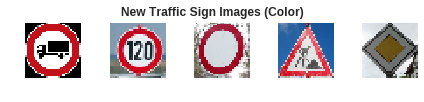

In [0]:
show_image_list(new_imgs, new_img_lbs_text, "New Traffic Sign Images (Color)", cols=len(new_imgs), 
                fig_size=(6,6), show_ticks=False)

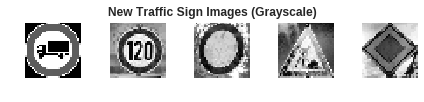

In [0]:
show_image_list(new_img_grayscale_clahe, new_img_lbs_text, "New Traffic Sign Images (Grayscale)", cols=len(new_img_grayscale_clahe), 
                fig_size=(6,6), show_ticks=False)

The Images were chosen because of the following:
* They represent different traffic signs that we currently classify
* They vary in shape and color
* They are under different lighting conditions (the 4th one has sunlight reflection)
* They are under different orientations (the 3rd one is slanted)
* They have different background
* The last image is actually a design, not a real picture, and we wanted to test the model against it to see if it recognizes it
* Some of them are in under-represented classes

### Predict the Sign Type for Each Image

In [0]:
# First normalise the images
new_img_grayscale_clahe_normalised = normalise_images(new_img_grayscale_clahe, X_train_grayscale_equalized)

In [0]:
# Convert to a format Tensorflow understands
new_img_grayscale_clahe_normalised = np.reshape(new_img_grayscale_clahe_normalised, (new_img_grayscale_clahe_normalised.shape[0], 32, 32, 1))

In [0]:
preds = me_g_norm_drpt_0_75_3x3.predict(new_img_grayscale_clahe_normalised)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_Norm_3x3_Dropout_0.75.chkpt


In [0]:
# Let's run the predictions now
preds = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised)

INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [0]:
preds

array([ 8, 12, 15, 25, 16])

In [0]:
preds

array([16,  8, 15, 25, 12])

### Analyze Prediction Performance

#### Calculating accuracy

In [0]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[Grayscale Normalised] Predictional accuracy on new images: {0}%".format(new_img_grayscale_norm_pred_acc * 100))

[Grayscale Normalised] Predictional accuracy on new images: 100.0%


In [0]:
new_img_grayscale_norm_pred_acc = np.sum(new_img_lbs == preds) / len(preds)
print("[Grayscale Normalised] Predictional accuracy on new images: {0}%".format(new_img_grayscale_norm_pred_acc * 100))

[Grayscale Normalised] Predictional accuracy on new images: 100.0%


We achieve perfect accuracy of 100% on the new images. On the original test set, we achieved 97.75% accuracy. We could explore blurring our new images or modifying contrast to see how the model handles those changes in the future.

Next we will explore the distribution of our top 5 Softmax probabilities for each image and will plot them.

#### Calculating Top 5 Softmax Probabilities

In [0]:
new_img_grayscale_clahe_norm_top5_probs = me_g_clahe_norm_take2_drpt_0_50_3x3.predict(new_img_grayscale_clahe_normalised, top_5=True)


INFO:tensorflow:Restoring parameters from ./models/EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50.chkpt


In [0]:
new_img_grayscale_clahe_norm_softmax_lbs_names = list(map(lambda cids: class_ids_to_labels(cids), new_img_grayscale_clahe_norm_top5_probs.indices))

In [0]:
new_img_grayscale_clahe_norm_softmax_and_labels = (list(zip(new_img_grayscale_clahe_norm_top5_probs.values, new_img_grayscale_clahe_norm_softmax_lbs_names)))

In [0]:
# Let's see the Softmax probabilities for the first image to have an idea what the format looks like
new_img_grayscale_clahe_norm_top5_probs.values[0]

array([9.9992013e-01, 5.8356309e-05, 1.0139472e-05, 9.4454763e-06,
       1.3381263e-06], dtype=float32)

In [0]:
# Let's do the same for the predicted labels
new_img_grayscale_clahe_norm_top5_probs.indices[0]

array([16,  9, 23, 17, 40], dtype=int32)

In [0]:
# And now let's see what our zipped list of softmax probabilities with label names looks like
new_img_grayscale_clahe_norm_softmax_and_labels[0]

(array([9.9992013e-01, 5.8356309e-05, 1.0139472e-05, 9.4454763e-06,
        1.3381263e-06], dtype=float32),
 ['Vehicles over 3.5 metric tons prohibited',
  'No passing',
  'Slippery road',
  'No entry',
  'Roundabout mandatory'])

### Visualising Our SoftMax Probabilities

We show each new images next to its computed top 5 softmax probabilities. The bars in green indicates the ground truth label.

In [0]:
def show_imgs_softmax_probs(imgs, softmax_probs_lb_names, correct_lbs, fig_size=(15, 7)):
    rows = len(imgs)
    fg, ax = plt.subplots(nrows=rows, ncols=2, figsize=fig_size)
    for i, prob_lb in enumerate(softmax_probs_lb_names):
        correct_lb = correct_lbs[i]
        img = imgs[i]
        ax[i,0].imshow(img)
        ax[i,0].axis("off")

        lb_names = prob_lb[1]
        y_pos = np.arange(len(lb_names))
        vals = prob_lb[0]
        for j in range(0, len(lb_names)):
            c = "g" if lb_names[j] == correct_lb else "r"
            ax[i, 1].barh(j, vals[j], color=c, label="{0}".format(lb_names[j]))

        ax[i, 1].set_yticks(y_pos)
        ax[i, 1].set_yticklabels(lb_names)
        ax[i, 1].invert_yaxis()  # labels read top-to-bottom
        ax[i, 1].set_xlabel('Class')
        ax[i, 1].set_title('Softmax')  
        ax[i, 1].set_xscale('log')

        ax[i, 1].legend(loc='lower right')
    
    fg.tight_layout()
    plt.show()

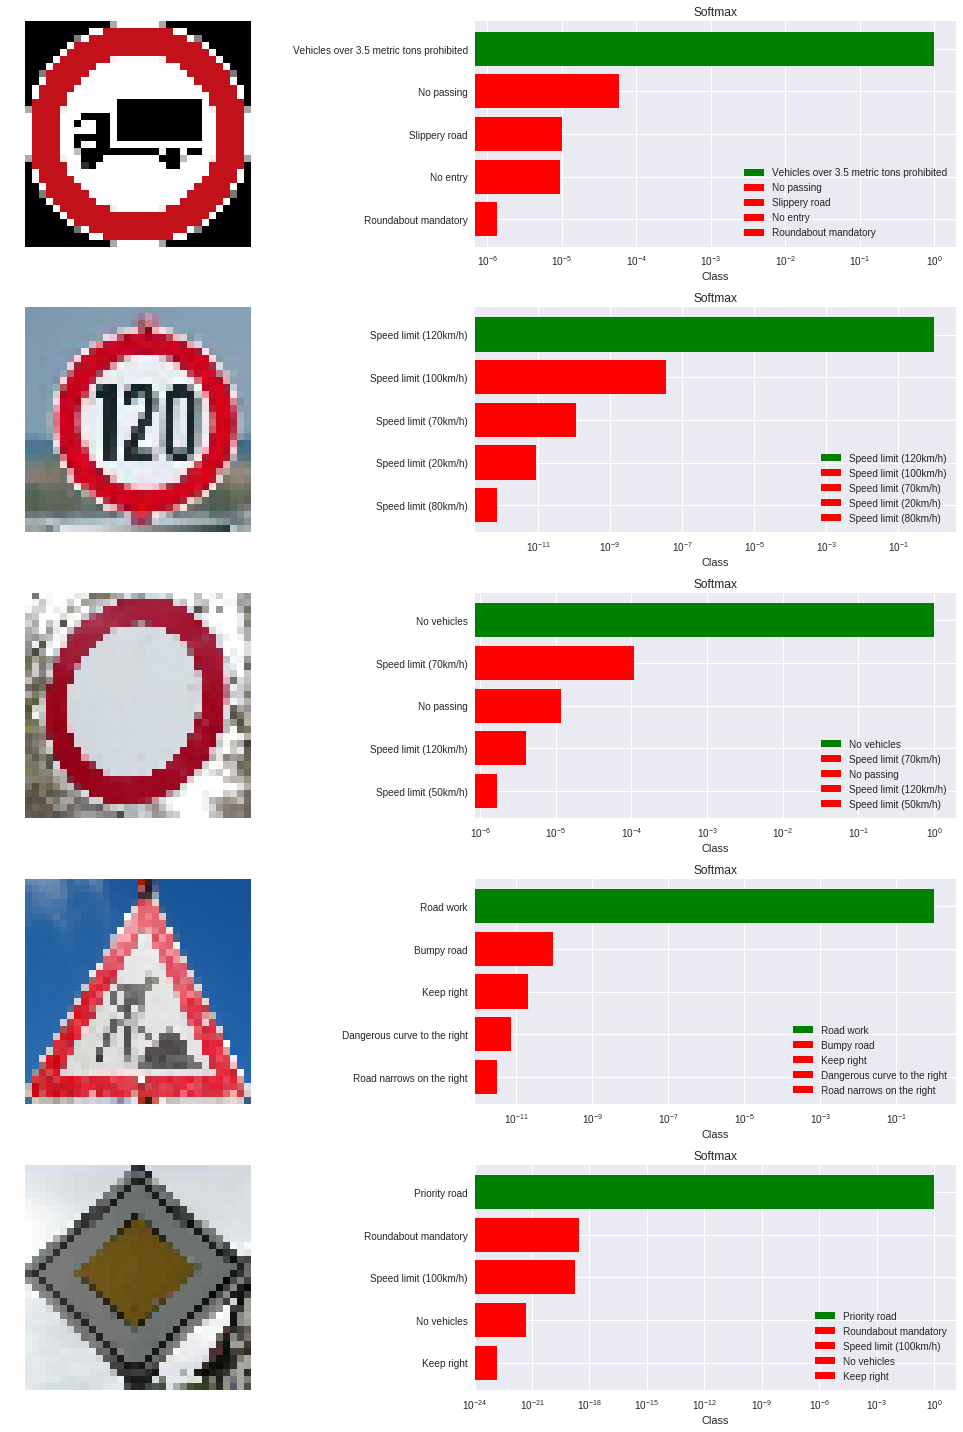

In [0]:
show_imgs_softmax_probs(new_imgs, new_img_grayscale_clahe_norm_softmax_and_labels, new_img_lbs_text, fig_size=(15, 20))

We can clearly see that our model quite confident in its predictions. In the worst case (last image), the 2 most likely prediction has a probability of around 10<sup>-3</sup>. In fact our model struggles most on the last image, which I believe is actually a design a not even a real picture. Overall, we have developed a strong model!

---

# Visualizing feature maps

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [0]:
selected_new_img = np.reshape(new_img_grayscale_clahe[0], (32, 32, 1))

Fetching tensor: EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50/conv_0_relu:0
Shape of activation layer: (1, 30, 30, 32)


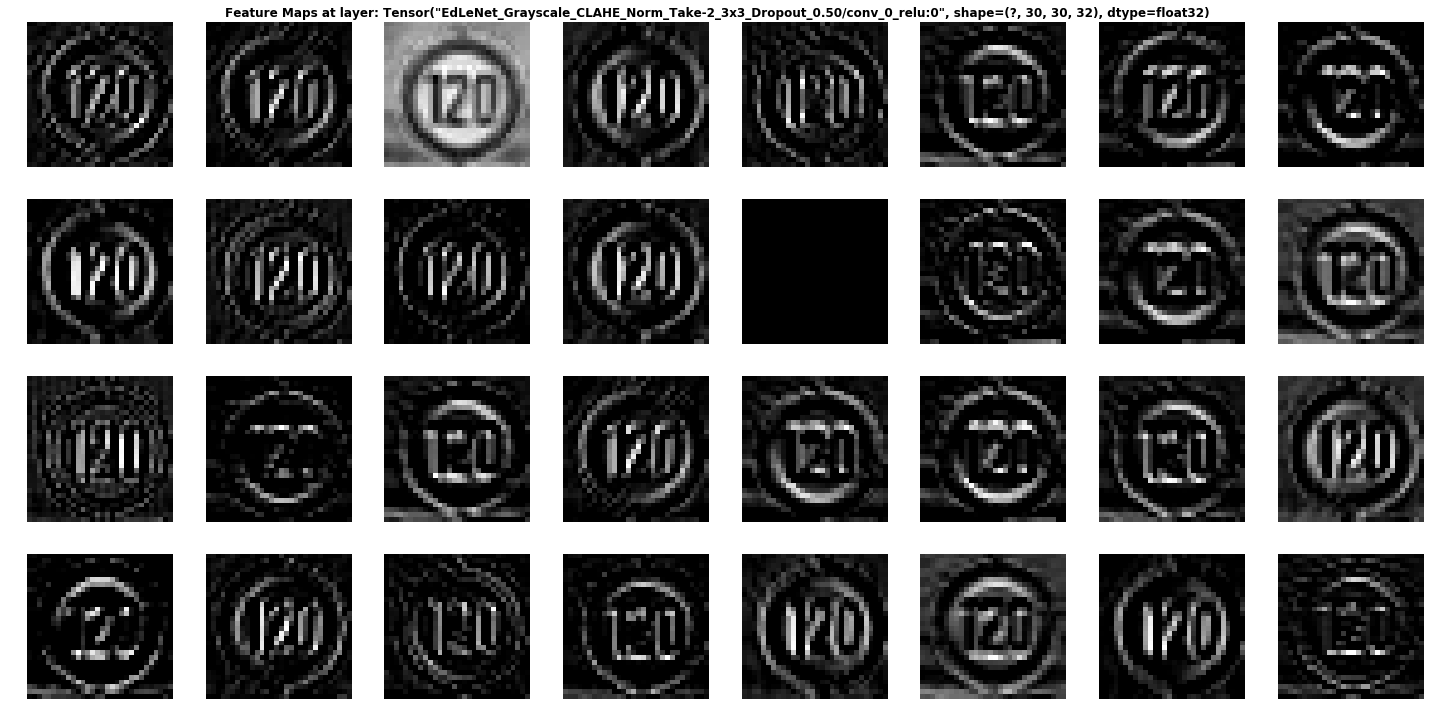

In [0]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=0, fig_size=(20, 10), title_y_pos=1)

We can see that the network is focusing a lot on the edges of the circle and somehow on the _120_. The background is ignored.

Fetching tensor: EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50/conv_1_relu:0
Shape of activation layer: (1, 13, 13, 64)


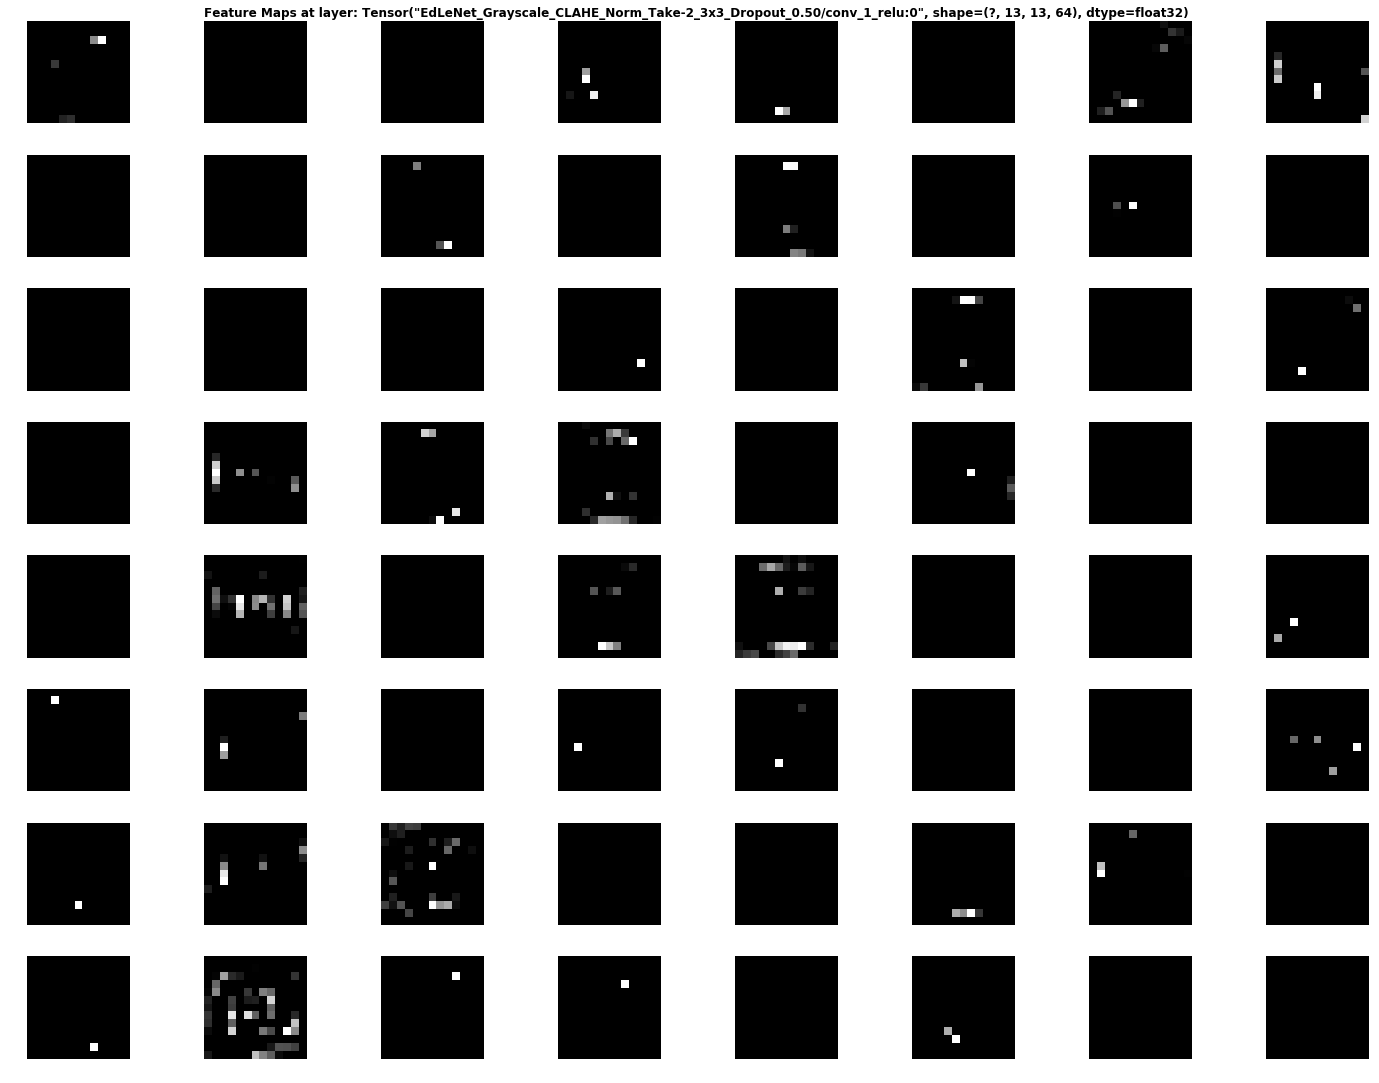

In [0]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=1, fig_size=(20, 15), title_y_pos=1)

It is rather hard to determine what the network is focusing on in layer 1, but it seems to "activate" around the edges of the circle and in the middle, where our _120_ is printed.

Fetching tensor: EdLeNet_Grayscale_CLAHE_Norm_Take-2_3x3_Dropout_0.50/conv_2_relu:0
Shape of activation layer: (1, 4, 4, 128)


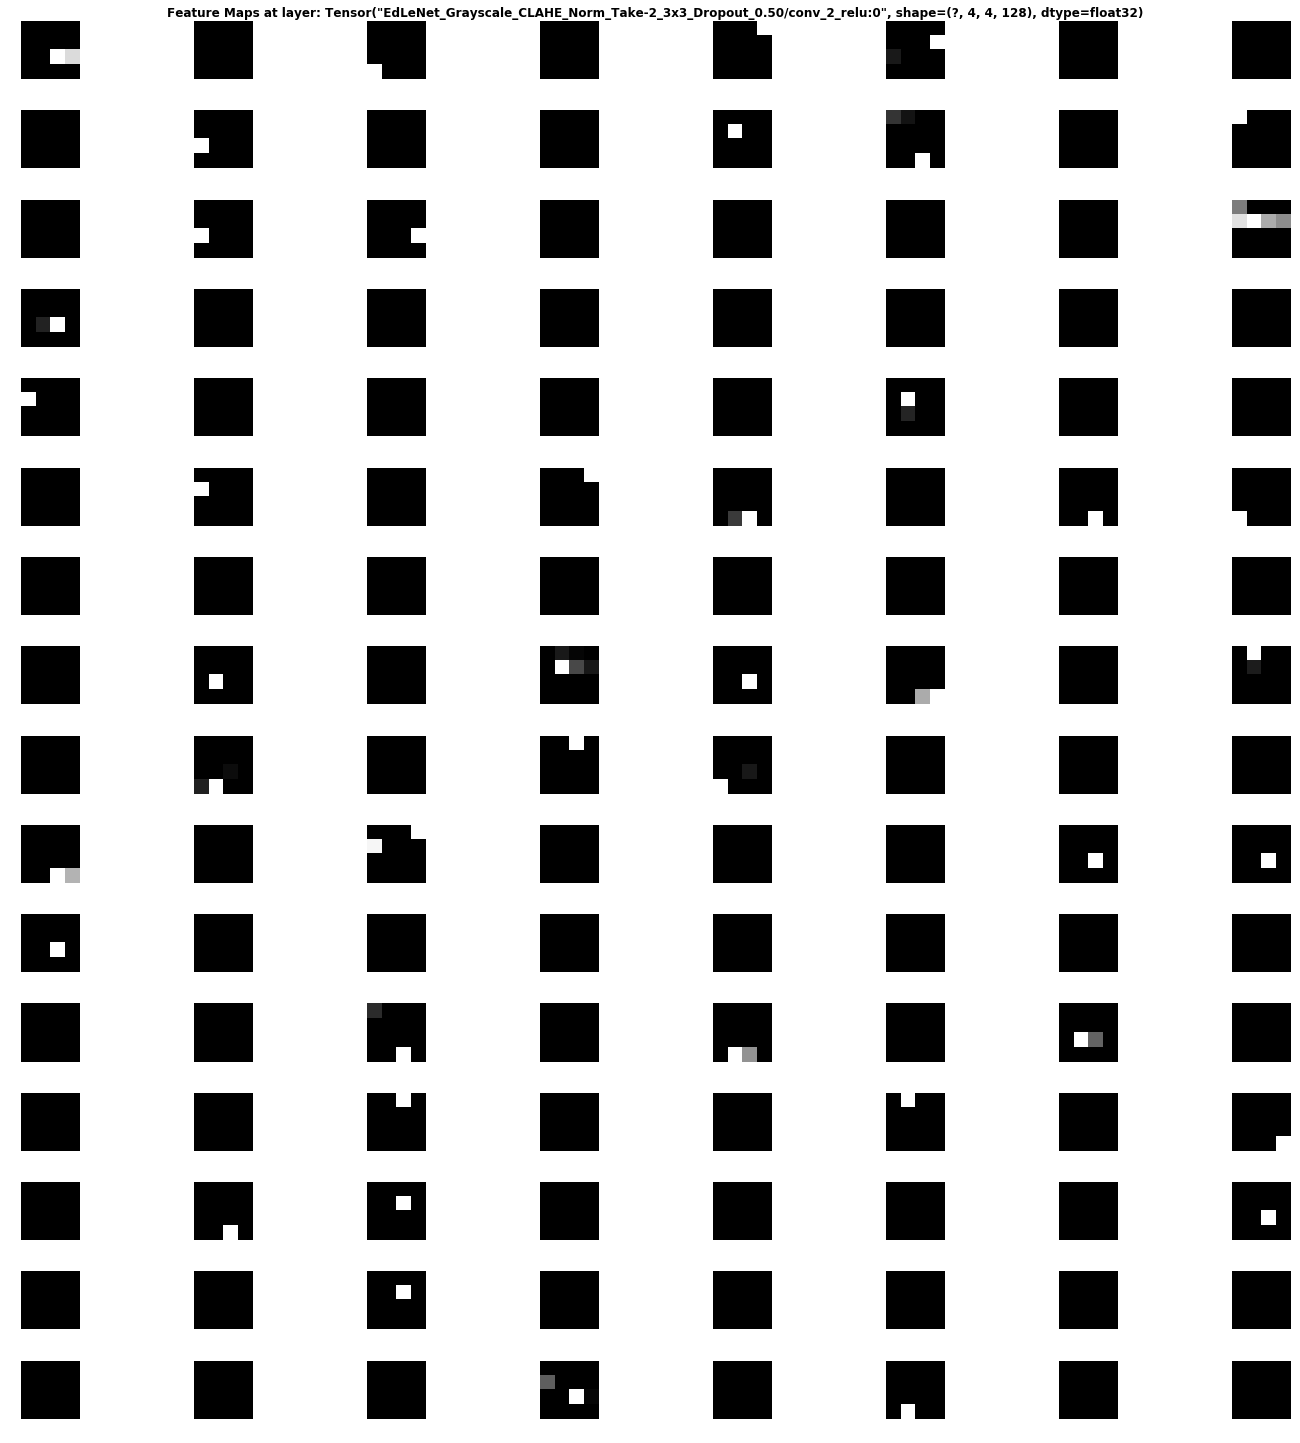

In [0]:
me_g_clahe_norm_take2_drpt_0_50_3x3.show_conv_feature_maps(selected_new_img, conv_layer_idx=2, fig_size=(20, 20), title_y_pos=1)

This activation map is also hard to decipher... But it seems the network reacts to stimuli on the _edges_ and in the middle once again.